<a href="https://colab.research.google.com/github/Lamblador/IR_expert_system/blob/main/Koshelev_IR_expert_system_2_17cls_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IR spectral analysis of organic and coordination compounds via machine learning and neural networks
By: Koshelev Daniil 

Based on some code form: https://github.com/rayguna/IR-Spectra-Analyzer
Предыдущая часть: https://github.com/Lamblador/IR_expert_system/blob/main/Koshelev_IR_expert_system_1_Dataset_Preparation.ipynb

-Work in progress (last updated:30/05/2023)-

B. Цель данного блокнота

Целью этого блокнота является обучение примитивной модели распознавания всего лишь 15 классов (функциональных групп) в спектре из 1800 точек в диапазоне 500-4100 [1/cm] 

C. План реализации

1. Импортировать табличные данные разметки классов по CAS и табличные данные уже обработанных спектров нужного диапазона.
2. Создать объект класса Dataset
3. Реализовать код для обучения модели.
4. Реализовать саму модель.
5. Обучить модель.
6. Оценить точность модели в мультиклассовом анализе (label_ranking_average_precision_score).
7. Собрать статистику.
8. Добавить слой внимания

NOTES
1. Импортированы табличные данные.
2. Написана несколько версий модели. 
3. Разработаны функции для описания статистики модели.
4. Применен планировщик обучения. Получена точность 0,8.
5. Убран AdMaxPool
6. 

Клонирование данных с GitHub. На сайте выложены как исходные списки веществ, так и скачанные спектры соединений, которые были запарсены кодом ниже.

In [1]:
!git clone https://github.com/Lamblador/IR_expert_system.git

Cloning into 'IR_expert_system'...
remote: Enumerating objects: 16940, done.
remote: Counting objects: 100% (2097/2097), done.
remote: Compressing objects: 100% (1958/1958), done.
remote: Total 16940 (delta 144), reused 2084 (delta 135), pack-reused 14843
Receiving objects: 100% (16940/16940), 1.01 GiB | 16.47 MiB/s, done.
Resolving deltas: 100% (504/504), done.
Updating files: 100% (16705/16705), done.


In [2]:
# Установка нужных пакетов
from IPython.core.display import clear_output
!pip install --upgrade jcamp
!pip install torchmetrics
!pip install peakutils
clear_output()

In [3]:
# Вводятся нужные импорты
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import os
import numpy as np
import torch
import os
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import torch.nn as nn
from peakutils.peak import indexes as index_utils

In [4]:
import random

import torch
import torch.nn as nn
from torchvision import datasets, transforms


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_random_seed(42)

# Импорт табличных данных

In [5]:
#Считывание датасета
def read_dataset(dataset_name):
  '''
  Function for reading dataset into pandas Dataframe from /IR_expert_system/data/datasets/

  dataset_name - name of dataset's folder to read

  return pd.Dataframe with whole dataset

  parameters:
      name = ['dataset3']
          dataset3 - dataset made from reading most of jcam files, with padded y, interpolated x and peak layer. Saved in 10 pieces. 
  '''
  df_list = []
  # choose current directory
  curr_directory = os.getcwd()
  os.chdir(curr_directory)  # set to current directory
  files = glob.glob('/content/IR_expert_system/data/datasets/'+dataset_name+'/*.pkl')  # look for files without extension. Returns a list.
  # Try to read the file. If can't be read, skip it.
  #print(files)
  for i, file in tqdm(enumerate(files)):
      df = pd.read_pickle(file)
      df_list.append(df)
  #print(df_list)
  result = pd.concat(df_list)
  return result

dataset_df_readed = read_dataset('dataset3')
dataset_df_readed

10it [00:01,  7.55it/s]


,index,title,jcamp-dx,data type,origin,owner,molform,$nist source,spectrometer/data system,state,...,number of interferograms averaged per single channel spectrum,sample description,temperature,$spectra version,$uncertainty in y,pressure,x1,y1,y_peak,x_peak
cas registry no,,,,,,,,,,,,,,,,,,,,,
19780-66-6,19780-66-6,3-Ethyl-2-methyl-1-pentene,4.24,INFRARED SPECTRUM,NIST Mass Spectrometry Data Center,NIST Standard Reference Data Program\nCollecti...,C 8 H 16,MSDC-IR,HP-GC/MS/IRD,gas,...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.0006741000106558204, 0.0006741000106558204,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[890, 1382, 1458, 1642, 2882, 2938, 2970, 3078]"
1578-63-8,1578-63-8,.alpha.-Fluorophenylacetic acid,4.24,INFRARED SPECTRUM,EPA-IR VAPOR PHASE LIBRARY,SRD/NIST\nCollection (C) 2018 copyright by the...,C 8 H 7 F O 2,MSDC-IR,NaN,gas,...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.008534999564290047, 0.008534999564290047, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[556, 582, 608, 646, 668, 696, 754, 866, 890, ..."
112-95-8,112-95-8,Eicosane,4.24,INFRARED SPECTRUM,Sadtler Research Labs Under US-EPA Contract,NIST Standard Reference Data Program\nCollecti...,C 20 H 42,MSDC-IR,NaN,gas,...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.02957835979759693, 0.02981981635093689, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1462, 2866, 2934, 2966]"
107-51-7,107-51-7,OCTAMETHYLTRISILOXANE,4.24,INFRARED SPECTRUM,DOW CORNING CORP.,COBLENTZ SOCIETY\nCollection (C) 2018 copyrigh...,C8 H24 O2 Si3,COBLENTZ,PERKIN-ELMER 521 (GRATING),"SOLUTION (5% IN CCl4 FOR 3800-1275, 2% IN CS2 ...",...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.19924922066729778, 0.20679426685319413, 0.2...","[0.6, 0.7, 0.8, 0.9, 1.0, 0.9, 0.8, 0.7, 0.6, ...","[508, 572, 654, 690, 754, 792, 820, 842, 876, ..."
1073-67-2,1073-67-2,"Benzene, 1-chloro-4-ethenyl-",4.24,INFRARED SPECTRUM,Sadtler Research Labs Under US-EPA Contract,NIST Standard Reference Data Program\nCollecti...,C 8 H 7 Cl,MSDC-IR,NaN,gas,...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.02410739939659834, 0.024935759603977203, 0....","[0.9, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.39999999...","[502, 534, 574, 606, 634, 662, 694, 726, 762, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6137-03-7,6137-03-7,3-Ethyl-2-pentanone,4.24,INFRARED SPECTRUM,NIST Mass Spectrometry Data Center,NIST Standard Reference Data Program\nCollecti...,C 7 H 14 O,MSDC-IR,HP-GC/MS/IRD,gas,...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.00034679999225772917, 0.0003467999922577291...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[958, 1138, 1174, 1254, 1358, 1462, 1726, 2886..."
603-11-2,603-11-2,3-NITROPHTHALIC ACID,4.24,INFRARED SPECTRUM,"WYANDOTTE CHEMICALS CORP., WYANDOTTE, MICHIGAN...",COBLENTZ SOCIETY\nCollection (C) 2018 copyrigh...,C8 H5 N O6,COBLENTZ,"Not specified, most likely a prism, grating, o...",SOLID (MINERAL OIL MULL),...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.42100000381469727, 0.42100000381469727, 0.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[660, 684, 748, 776, 830, 874, 908, 932, 968, ..."
87-61-6,87-61-6,"Benzene, 1,2,3-trichloro-",4.24,INFRARED SPECTRUM,Sadtler Research Labs Under US-EPA Contract,NIST Standard Reference Data Program\nCollecti...,C 6 H 3 Cl 3,MSDC-IR,NaN,gas,...,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.03411715663969517, 0.03504668548703194, 0.0...","[0.29999999999999993, 0.3999999999999999, 0.5,...","[514, 698, 742, 786, 1046, 1162, 1194, 1434, 1..."


In [6]:
labels_df = pd.read_csv('/content/IR_expert_system/data/nist_ir_spectra_inchi_group_list.csv')
labels_df = labels_df.set_index("CAS")
labels_df

,Name,Formula,Mw,Elements,InChi,SMILES,alkane,methyl,alkene,alkyne,...,aromatics,alkyl halides,esters,ketones,aldehydes,carboxylic acids,ether,acyl halides,amides,nitro
CAS,,,,,,,,,,,,,,,,,,,,,
100-00-5,"Benzene, 1-chloro-4-nitro-",C6H4ClNO2,156.993056,"['C', 'H', 'Cl', 'N', 'O']",InChI=1/C6H4ClNO2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H,[O-][N+](=O)c1ccc(Cl)cc1,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
100-01-6,p-Nitroaniline,C6H6N2O2,138.042927,"['C', 'H', 'N', 'O']",InChI=1/C6H6N2O2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H...,Nc1ccc(cc1)[N+]([O-])=O,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
100-02-7,"Phenol, 4-nitro-",C6H5NO3,139.026943,"['C', 'H', 'N', 'O']","InChI=1/C6H5NO3/c8-6-3-1-5(2-4-6)7(9)10/h1-4,8H",Oc1ccc(cc1)[N+]([O-])=O,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1000-49-3,N-butyltrimethylsilane,C7H18Si,130.117777,"['C', 'H', 'Si']","InChI=1/C7H18Si/c1-5-6-7-8(2,3)4/h5-7H2,1-4H3",CCCC[Si](C)(C)C,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000-50-6,N-Butyldimethylchlorosilane,C6H15ClSi,150.063155,"['C', 'H', 'Cl', 'Si']","InChI=1/C6H15ClSi/c1-4-5-6-8(2,3)7/h4-6H2,1-3H3",CCCC[Si](C)(C)Cl,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99-97-8,"Benzenamine, N,N,4-trimethyl-",C9H13N,135.104799,"['C', 'H', 'N']","InChI=1/C9H13N/c1-8-4-6-9(7-5-8)10(2)3/h4-7H,1...",CN(C)c1ccc(C)cc1,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999-78-0,"2-Pentyne, 4,4-dimethyl-",C7H12,96.093900,"['C', 'H']","InChI=1/C7H12/c1-5-6-7(2,3)4/h1-4H3",CC#CC(C)(C)C,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999-81-5,"Ammonium chloride, 2-chloroethyltrimethyl-",C5H13ClN.Cl,157.042505,"['C', 'H', 'Cl', 'N', 'Cl']","InChI=1/C5H13ClN.ClH/c1-7(2,3)5-4-6;/h4-5H2,1-...",[Cl-].C[N+](C)(C)CCCl,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Импорт данных и обработка спектров

In [7]:
# from jcamp import jcamp_readfile
# nist_ir_spectra_list_with_group = pd.read_csv('/content/IR_expert_system/data/nist_ir_spectra_inchi_group_list.csv')
# # Create an empty list to store spectra data
# ref_spectra = []
# # choose current directory
# curr_directory = os.getcwd()
# os.chdir(curr_directory)  # set to current directory
# files = glob.glob('/content/IR_expert_system/downloaded_jcamp/ir/*')  # look for files without extension. Returns a list.
# # Try to read the file. If can't be read, skip it.
# dataset_dic = {}
# for i, file in enumerate(files):
    
#     #print(file)
#     try:
#         # read jcamp file using the jcamp class and store data into the
#         # ref_spectra list
#         sample = jcamp_readfile(file)
#         #Forming data into the types
#         sample['x'] = sample['x'].astype(np.float32)
#         sample['y'] = sample['y'].astype(np.float32)
#         sample['firstx'] = np.float32(sample['x'][0])
#         #print(type(sample['firstx']))
#         sample['deltax'] = ((np.float32(sample['firstx'])-np.float32(sample['lastx']))/np.float32(sample['npoints']))
#         sample['npoints'] = int(sample['npoints'])    
#         # uniformize data, #1:
#         # check yunits: If yunits is in transmission, change it to absorbance.
#         # Later create a function to uniformize units
#         if sample['yunits'] == "ABSORBANCE":
#             pass 

#         elif sample['yunits'] == "TRANSMISSION" or sample['yunits'] == "TRANSMITTANCE":
            
#             sample['y'] = 1 - sample['y']
#             sample['yunits'] = "ABSORBANCE"
            
#             #normalize
           
#         # check xunits: if in microns, change to 1/cm

#         if sample['xunits'] == "MICROMETERS":
#             sample['x'] = 10000 / sample['x']
#             sample['xunits'] = '1/CM'
#             sample['firstx'] = np.float32(sample['x'][0])
#             sample['lastx'] = np.float32(sample['x'][int(sample['npoints'])-1])
#             sample['deltax'] = ((np.float32(sample['firstx'])-np.float32(sample['lastx']))/np.float32(sample['npoints']))
#             #if sample['deltax'] == np.nan: print(float(sample['firstx'])-float(sample['lastx'])), float(sample['npoints'])
#             sample['maxx'] =  np.float32(max(sample['x']))
#             sample['minx'] =  np.float32(min(sample['x']))
#         # check deltax: if Nan, change to (maxx-minx)/npoints
#         #if sample['deltax'] == np.nan: sample['deltax'] = ((float(sample['firstx'])-float(sample['lastx']))/float(sample['npoints']))

#         # !Still need to uniformize x-axis range and uniformize x-axis intervals.
#         #Flitting the x array if it is not in min_to_max order
#         if sample['x'][0] > sample['x'][3]: 
#            #print(sample['x'])
#            sample['x'] = np.flip(sample['x'])
#            #print(sample['x'])
#            sample['y'] = np.flip(sample['y'])
#            sample['firstx'] = np.float32(sample['x'][0])
#            sample['lastx'] = np.float32(sample['x'][int(sample['npoints'])-1])
           
        
#         #Saving data to dictionary under cas num
#         dataset_dic[sample['cas registry no']] = sample
#         #print(sample['cas registry no'])
#         # Nan check
#         if np.isnan(sample['y']).any(): print("Reading jcamp problem! Nan observed in Y")
                

#     except:
#          print("File can't be read, please check:", file)
#          continue

# #print(dataset_dic)

In [8]:
# dataset_df = pd.DataFrame(dataset_dic)
# dataset_df = dataset_df.transpose()
# dataset_df[['x', 'y', 'minx', 'maxx', 'npoints']]

In [9]:
# #Добавление к краям с исходным шагом крайнего значения y.
# def padding_ir_below(x, y, low_border):
#   '''
#     x, y - array-like data
#     low_border - border until which padding will continue 

#     return padded x and y as lists
#   '''
#   x, y = list(x), list(y)
#   deltax = x[1]-x[0]
#   next_x = x[0]-deltax
#   while next_x > low_border:
#     x.insert(0, next_x)
#     y.insert(0, y[0])
#     next_x = x[0]-deltax
#   #Последняя итерация чтобы выйти за границу интерполирования
#   x.insert(0, next_x)
#   y.insert(0, y[0])
#   next_x = x[0]-deltax
#   return x, y

# def padding_ir_above(x, y, high_border):
#   '''
#     x, y - array-like data
#     high_border - border until which padding will continue 


#     return padded x and y as lists
#   '''
#   x, y = list(x), list(y)
#   deltax = x[1]-x[0]
#   next_x = x[-1]+deltax
#   while next_x < high_border:
#     x.append(next_x)
#     y.append(y[-1])
#     next_x = x[-1]+deltax
#   #Последняя итерация чтобы выйти за границу интерполирования
#   x.append(next_x)
#   y.append(y[-1])
#   next_x = x[-1]+deltax
#   return x, y

# from scipy import interpolate

# def interpolate_in_borders_with_delta(x, y, borders = [500, 4100], deltax = 2):
#   '''
#   x, y - array like data
#   borders - list of [low_border, high border]
#   deltax - increment of new data

#   returns new x, y data as lists with increment = deltax
#   '''
#   x, y = list(x), list(y)
#   f = interpolate.interp1d(x, y)
#   #print(f(x[0]))
#   x_new = []
#   for i in range(borders[0], borders[1], deltax):
#     x_new.append(i)
#   x_new = np.array(x_new)
#   y_new = f(x_new)
  
#   return x_new, y_new

# def find_peaks_indx(y):
#   index = index_utils(np.array(y), thres=0.05*max(y), min_dist=10, thres_abs = True)
#   return index

In [10]:
# x_list, y_list = [], []
# y_peak_indx_list = []
# errors = 0
# for i in tqdm(range(len(dataset_df[['x']]))):
#   try:
#       x, y = dataset_df[['x']].iloc[i].tolist(), dataset_df[['y']].iloc[i].tolist()
#       x1, y1 = padding_ir_below(x[0], y[0], 500.0)

#       x2, y2 = padding_ir_above(x1, y1, 4100.0)
  
#       x3, y3 = interpolate_in_borders_with_delta(x2, y2)
#       y_peak_indx = find_peaks_indx(y3)
#       y_peak_indx_list.append(y_peak_indx)
#       x_list.append(x3)
#       y_list.append(y3)
#   except ValueError:
#       #print(f'0: {len(x)}, {len(y)}, 1: {len(x1)}, {len(y1)}, 2: {len(x2)}, {len(y2)}')
#       errors +=1
#       x_list.append(np.nan)
#       y_list.append(np.nan) 
#       y_peak_indx_list.append(np.nan)
# print(f'Found {errors} errors')


In [11]:
# #Создаём дополнительный слой для входа в сеть, где +/- вокруг пика будет от 0 до 1, а вне - 0.
# #def print_peak_neighborhood(peak_indx, num_neighbors = 10):
# num_neighbors = 10
# y_masked_list = []
# for i in range(len(y_list)):
#   try:
#     y_masked = np.zeros(len(y_list[i]))
  
#     for j in y_peak_indx_list[i]:
#       for k in range(num_neighbors):
#           y_masked[j-k] = 1-(1/num_neighbors)*k
#           y_masked[j+k] = 1-(1/num_neighbors)*k
          
#       #print(y_masked[28:48])
      
          
      
#     y_masked_list.append(y_masked)
#   except:
#     y_masked_list.append(np.nan)

In [12]:
# x_serie = pd.Series(x_list)
# y_serie = pd.Series(y_list)
# y_peak_serie = pd.Series(y_masked_list)

In [13]:
# df = pd.DataFrame(x_serie, columns = ['x1'])
# df['y1'] = y_serie
# df['y_peak'] = y_masked_list

In [14]:
# dataset_df = dataset_df.reset_index()
# dataset_df1 = dataset_df.join(df, lsuffix='x')
# dataset_df1[['x', 'x1', 'y', 'y1', 'y_peak']]

In [15]:
# dataset_df1 = dataset_df.set_index('cas registry no')

In [16]:
dataset_df_labeled = labels_df.join(dataset_df_readed)
#dataset_df_labeled

In [17]:
dataset_df_labeled.columns

Index(['Name', 'Formula', 'Mw', 'Elements', 'InChi', 'SMILES', 'alkane',
       'methyl', 'alkene', 'alkyne',
       ...
       'number of interferograms averaged per single channel spectrum',
       'sample description', 'temperature', '$spectra version',
       '$uncertainty in y', 'pressure', 'x1', 'y1', 'y_peak', 'x_peak'],
      dtype='object', length=102)

In [18]:
dataset_df_labeled1 = dataset_df_labeled[['Name', 'Formula', 'Mw', 'Elements', 'InChi', 'SMILES', 'alkane',
       'methyl', 'alkene', 'alkyne', 'alcohols', 'amines', 'nitriles',
       'aromatics', 'alkyl halides', 'esters', 'ketones', 'aldehydes',
       'carboxylic acids', 'ether', 'acyl halides', 'amides', 'nitro',
       'title',
       'molform',
       'x', 'y', 'x1', 'y1', 'y_peak']]
#dataset_df_labeled1

In [19]:
spectra_x =dataset_df_labeled1.iloc[:,-1]
spectra_x_t = torch.Tensor(spectra_x[0])
spectra_x_t

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [20]:
len(dataset_df_labeled1.iloc[:,-3][0])

1800

#Добавление слоёв со всеми положениями максимумов для классов

С "https://en.wikipedia.org/wiki/Infrared_spectroscopy_correlation_table" и Koshelev_IR_expert_system_5_72kNN_ML (https://colab.research.google.com/drive/1DcntOKEOec_MPN_CIZywpjZuo2OjTAGm#scrollTo=_PmXuJTkRr07)

In [21]:
all_keys_list_short = ['C─H alkyl methyl 1260 strong/1380 weak/2870 medium to strong/2960 medium to strong',
 'C─H alkyl methylene 1470 strong/2850 medium to strong/2925 medium to strong',
 'C─H alkyl methine 2890 weak',
 'C─H vinyl C═CH2 900 strong/2975 medium/3080 medium',
 'C─H vinyl C═CH 3020 medium',
 'C─H vinyl monosubstituted alkenes 900 strong/990 strong',
 'C─H vinyl cis-disubstituted alkenes 670–700 strong',
 'C─H vinyl trans-disubstituted alkenes 965 strong',
 'C─H vinyl trisubstituted alkenes 800–840 strong to medium',
 'C─H aromatic benzene/sub. benzene 3070 weak',
 'C─H aromatic monosubstituted benzene 700–750 strong',
 'C─H aromatic monosubstituted benzene 690–710 strong',
 'C─H aromatic ortho-disub. benzene 750 strong',
 'C─H aromatic meta-disub. benzene 750–800 strong',
 'C─H aromatic meta-disub. benzene 860–900 strong',
 'C─H aromatic para-disub. benzene 800–860 strong',
 'C─H alkynes any 3300 medium',
 'C─H aldehydes any 2720 medium',
 'C─H aldehydes any 2820 medium',
 'C═C acyclic C═C monosub. alkenes 1645 medium',
 'C═C acyclic C═C 1,1-disub. alkenes 1655 medium',
 'C═C acyclic C═C cis-1,2-disub. alkenes 1660 medium',
 'C═C acyclic C═C trans-1,2-disub. alkenes 1675 medium',
 'C═C acyclic C═C trisub., tetrasub. alkenes 1670 weak',
 'C═C conjugated C═C dienes 1600 strong/1650 strong',
 'C═C with benzene ring dienes 1625 strong',
 'C═C with C═O dienes 1600 strong',
 'C═C C═C (both sp2) any 1640–1680 medium',
 'C═C aromatic C═C any 1450/1500/1580/1600 weak to strong (usually 3 or 4)',
 'C═C C≡C terminal alkynes 2100–2140 weak',
 'C═C C≡C disubst. alkynes 2190–2260 very weak (often indistinguishable)',
 'C=O aldehyde/ketone saturated aliph./cyclic 6-membered 1720 ',
 'C=O aldehyde/ketone α,β-unsaturated 1685 ',
 'C=O aldehyde/ketone aromatic ketones 1685 ',
 'C=O aldehyde/ketone aldehydes 1725 influenced by conjugation (as with ketones)',
 'C=O carboxylic acids/derivates saturated carboxylic acids 1710 ',
 'C=O carboxylic acids/derivates unsat./aromatic carb. acids 1680–1690 ',
 'C=O carboxylic acids/derivates esters and lactones 1735 influenced by conjugation and ring size (as with ketones)',
 'C=O carboxylic acids/derivates anhydrides 1760 ',
 'C=O carboxylic acids/derivates anhydrides 1820 ',
 'C=O carboxylic acids/derivates acyl halides 1800 ',
 'C=O carboxylic acids/derivates amides 1650 associated amides',
 'C=O carboxylic acids/derivates amino acid zwitterions 1550–1610 ',
 'O─H alcohols, phenols low concentration 3610–3670/high concentration 3200–3400 broad',
 'O─H carboxylic acids low concentration 3500–3560/high concentration 3000 broad',
 'N─H primary amines any 3400–3500 strong/1560–1640 strong',
 'N─H secondary amines any > 3000 weak to medium',
 'N─H ammonium ions any 2400–3200 multiple broad peaks',
 'C─O alcohols primary 1040–1060 strong, broad',
 'C─O alcohols secondary ~ 1100 strong',
 'C─O alcohols tertiary 1150–1200 medium',
 'C─O phenols any 1200',
 'C─O ethers aliphatic 1120',
 'C─O ethers aromatic 1220–1260',
 'C─O carboxylic acids any 1250–1300',
 'C─O esters any 1100–1300 two bands (distinct from ketones, which do not possess a C─O bond)',
 'C─N aliphatic amines any 1020–1220 often overlapped',
 'C─N C═N any 1615–1700 similar conjugation effects to C═O',
 'C─N C≡N (nitriles) unconjugated 2250 medium',
 'C─N C≡N (nitriles) conjugated 2230 medium',
 'C─N R─N─C (isocyanides) any 2165–2110',
 'C─N R─N═C═S (isothiocyanates) any 2140–1990',
 'C─X fluoroalkanes ordinary 1000–1100',
 'C─X fluoroalkanes trifluoromethyl 1100–1200 two strong, broad bands',
 'C─X chloroalkanes any 540–760 weak to medium',
 'C─X bromoalkanes any 500–600 medium to strong',
 'C─X iodoalkanes any 500 medium to strong',
 'N─O nitro compounds aliphatic 1540 stronger/aliphatic 1380 weaker',
 'N─O nitro compounds aromatic 1520 lower/1350 lower if conjugated',
 'P─C Organophosphorus compound aromatic 1440-1460 medium',
 'P─O phosphorus oxide bonded 1195-1250 strong',
 'P─O phosphorus oxide free 1250-1300 strong']

In [22]:
#Составляем словарь {класс: {волновое число проявления:сила проявления из key_worlds = ['strong', 'medium', 'weak']}}
key_worlds = ['weak to strong',  'medium to strong', 'weak', 'medium','strong']
import re
all_band_dic = {}
for key in all_keys_list_short[-2:-1]:
  band_dic = {}
  #поиск в строке диапазонов значений формата 300-300
  r = '\d+-\d+' #Поиск диапазонов
  diap = re.findall(r, key)
  #поиск в строке значений формата 300
  r2 = '\d+' #Поиск отдельных чисел
  solos = re.findall(r2, key)
  #Проверка на повторение
  print('1', diap, solos)
  for num_solo in solos:
    print('1.1', num_solo)
    if int(num_solo) <=10: 
        solos.remove(num_solo)
        continue
    print('1.2', solos)   
  for num_diap in diap:
      if str(num_solo) in str(num_diap): 
        solos.remove(num_solo)
      print('1.3', solos)
        
      
  print('2', diap, solos)
  all_nums = diap+solos
  print(all_nums)
  #поиск и сохранение ключевых слов, удаление из строки названия уже найденых
  class_keys = []
  for key_world in key_worlds:
      class_key = key
      if key_world in class_key: 
        class_keys.append(key_world)
        class_key.replace(key_world, '')
  #Составление словаря для класса
  #print(all_nums, class_keys)
  for i, num in enumerate(all_nums):
    try:
        band_dic[num] = class_keys[i]
    except IndexError: #Есть ключевого слова нет - ставим среднее значение
        band_dic[num] = 'medium'
  all_band_dic[key] = band_dic
print(all_band_dic)
print(len(all_band_dic))

1 ['1195-1250'] ['1195', '1250']
1.1 1195
1.2 ['1195', '1250']
1.1 1250
1.2 ['1195', '1250']
1.3 ['1195']
2 ['1195-1250'] ['1195']
['1195-1250', '1195']
{'P─O phosphorus oxide bonded 1195-1250 strong': {'1195-1250': 'strong', '1195': 'medium'}}
1


In [23]:
#Список полос колебаний
all_num_list = [
[1260,1380,2870,2960],
[1470,2850,2925],
[2890],
[2900,2975,3080],
[3020],
[900,990],
[670,700],
[965],
[800,840],
[3070],
[700,750],
[690,710],
[750],
[750,800],
[860,900],
[800,860],
[3300],
[2720],
[2820],
[1645],
[1655],
[1660],
[1675],
[1670],
[1600,1650],
[1625],
[1600],
[1640,1680],
[1450,1500,1580,1600],
[2100,2140],
[2190,2260],
[1720],
[1685],
[1685],
[1725],
[1710],
[1680,1690],
[1735],
[1760],
[1820],
[1800],
[1650],
[1550,1610],
[3610,3670, 3200,3400],
[3500,3560, 3000],
[3400,3500, 1560,1640],
[3000],
[2400,3200],
[1040,1060],
[1100],
[1150,1200],
[1200],
[1120],
[1220,1260],
[1250,1300],
[1100,1300],
[1020,1220],
[1615,1700],
[2250],
[2230],
[2165,2110],
[2140,1990],
[1000,1100],
[1100,1200],
[540,760],
[500,600],
[500],
[1540,1380],
[1520,1350],
[1440,1460],
[1195,1250],
[1250,1300],
]

In [24]:
#Проверка чётности полосы
for i, num_list in enumerate(all_num_list):
  for j, num in enumerate(num_list):
    if num%2 == 1: all_num_list[i][j]=all_num_list[i][j]+1
#all_num_list

In [25]:
dataset_df_labeled1.iloc[:,-3][0]

array([ 500,  502,  504, ..., 4094, 4096, 4098])

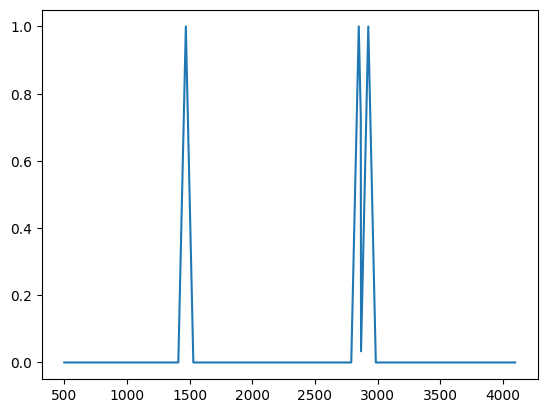

In [27]:
#Создаём дополнительный слой для каждого класса для входа в сеть, где +/- вокруг предполагаемого положения будет от 0 до 1, а вне - 0.
def print_peak_neighborhood(peak_indx, x, num_neighbors = 10):
  '''
  Cover neighbor of the class peak position with numbers between 0 and 1

  parameters:
  peak_indx - list of even wavenumber (1/cm) of peak possible position
  x - array like object of wavenumbers in spectra
  num_neighbors - nuber of neighbors which should be changed. Means the area of intrest of NN.
  '''
  class_peak_indx_list = []
  for num in peak_indx:
      try:
        y_mask_4_class = np.zeros(len(x))
        class_peak_indx_list.append(list(x).index(num))
      except TypeError:
        y_mask_4_class = np.zeros(1800)
        continue
  for i in class_peak_indx_list:
      for k in range(num_neighbors):
          y_mask_4_class[i-k] = 1-(1/num_neighbors)*k
          y_mask_4_class[i+k] = 1-(1/num_neighbors)*k
  return y_mask_4_class
#Проверка работоспособности
plt.plot(dataset_df_labeled1.iloc[:,-3][1], print_peak_neighborhood(all_num_list[1], dataset_df_labeled1.iloc[:,-3][1], num_neighbors = 30))

In [28]:
#Создаём дополнительный слой для каждого класса для входа в сеть, где +/- вокруг предполагаемого положения будет от 0 до 1, а вне - 0.
df_cls_attention = []
for i, num_list in enumerate(all_num_list):
  class_attention = print_peak_neighborhood(all_num_list[i], dataset_df_labeled1.iloc[:,-3][i], num_neighbors = 30)
  df_cls_attention.append(torch.Tensor(class_attention))
print(df_cls_attention)
df_cls_attention = torch.stack(df_cls_attention, dim=1).reshape((1800,72))
df_cls_attention.size()

[tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]),

torch.Size([1800, 72])

In [29]:
#Схлопываем все слои в один
df_cls_attention = torch.sum(df_cls_attention, dim=1)

In [74]:
#нормирование слоя на 1
df_cls_attention = df_cls_attention/max(df_cls_attention)

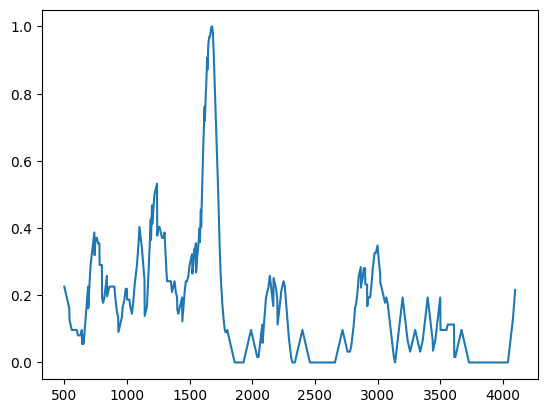

In [75]:
plt.plot(dataset_df_labeled1.iloc[:,-3][1], df_cls_attention)

# Создание класса Dataset

In [76]:
#Класс датасета на 17 классов со входом формата (2,1800)
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import datasets

class IRSpectraDataset(Dataset):
    def __init__(self, dataset_df_labeled):
        self.dataset_df = dataset_df_labeled
        self.spectra_labels = self.dataset_df.iloc[:,6:23]
        self.spectra_x = self.dataset_df.iloc[:,-3]
        self.spectra_y = self.dataset_df.iloc[:,-2]
        
    def __len__(self):
        return len(self.dataset_df)

    def __getitem__(self, idx):
        
        spectra_x = torch.Tensor(self.spectra_x.iloc[idx]).reshape((1, 1800))
        spectra_y = torch.Tensor(self.spectra_y.iloc[idx]).reshape((1, 1800))      
        spectra = torch.cat((spectra_x, spectra_y))
        
        label = torch.Tensor(self.spectra_labels.iloc[idx])
        #transform
        return spectra, label

In [77]:
#Класс датасета на 17 классов со входом формата (3,1800) +вход максимумов
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import datasets

class IRSpectraDatasetP(Dataset):
    def __init__(self, dataset_df_labeled):
        self.dataset_df = dataset_df_labeled
        self.spectra_labels = self.dataset_df.iloc[:,6:23]
        self.spectra_x = self.dataset_df.iloc[:,-3]
        self.spectra_y = self.dataset_df.iloc[:,-2]
        self.spectra_y_peak = self.dataset_df.iloc[:,-1]
        
    def __len__(self):
        return len(self.dataset_df)

    def __getitem__(self, idx):
        
        spectra_x = torch.Tensor(self.spectra_x.iloc[idx]).reshape((1, 1800))
        spectra_y = torch.Tensor(self.spectra_y.iloc[idx]).reshape((1, 1800)) 
        spectra_y_peak = torch.Tensor(self.spectra_y_peak.iloc[idx]).reshape((1, 1800))     
        spectra = torch.cat((spectra_x, spectra_y, spectra_y_peak))
        
        label = torch.Tensor(self.spectra_labels.iloc[idx])
        #transform
        return spectra, label

In [78]:
#Класс датасета на 17 классов со входом формата (4,1800)+вход максимумов+вход положений полос
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import datasets

class IRSpectraDatasetPA(Dataset):
    def __init__(self, dataset_df_labeled, df_cls_attention):
        self.dataset_df = dataset_df_labeled
        self.df_cls_attention = df_cls_attention
        self.spectra_labels = self.dataset_df.iloc[:,6:23]
        self.spectra_x = self.dataset_df.iloc[:,-3]
        self.spectra_y = self.dataset_df.iloc[:,-2]
        self.spectra_y_peak = self.dataset_df.iloc[:,-1]
        
    def __len__(self):
        return len(self.dataset_df)

    def __getitem__(self, idx):
        
        spectra_x = torch.Tensor(self.spectra_x.iloc[idx]).reshape((1, 1800))
        spectra_y = torch.Tensor(self.spectra_y.iloc[idx]).reshape((1, 1800)) 
        spectra_y_peak = torch.Tensor(self.spectra_y_peak.iloc[idx]).reshape((1, 1800))
        class_attention = torch.Tensor(self.df_cls_attention).reshape((1, 1800))
        spectra = torch.cat((spectra_x, spectra_y, spectra_y_peak, class_attention))
        
        label = torch.Tensor(self.spectra_labels.iloc[idx])
        #transform
        return spectra, label

In [82]:
#Создание объекта класса и разбиение на трейн,тест и вал в соотношении 7/2/1
from torch.utils.data import random_split
dataset_ir_spectra = IRSpectraDatasetPA(dataset_df_labeled1.dropna(), df_cls_attention)
train_size = int(0.7 * len(dataset_ir_spectra))
val_size = int(0.1 * len(dataset_ir_spectra))
test_size = len(dataset_ir_spectra) - train_size - val_size
train_dataset, test_dataset = random_split(dataset_ir_spectra, [train_size, int(test_size+val_size)])
test_dataset, val_dataset = random_split(test_dataset, [test_size, val_size])

In [83]:
# расчёт количества классов
classes = list(dataset_ir_spectra.spectra_labels.columns)
num_classes = len(classes)
num_classes

17

In [84]:
#Создание словарей перевода класса в индексы и обратно
cls2inx = {}
inx2cls= {}
for i, classs in enumerate(classes):
  cls2inx[f'{classs}']= i
  inx2cls[i] = classs
print(cls2inx)
print(inx2cls)

{'alkane': 0, 'methyl': 1, 'alkene': 2, 'alkyne': 3, 'alcohols': 4, 'amines': 5, 'nitriles': 6, 'aromatics': 7, 'alkyl halides': 8, 'esters': 9, 'ketones': 10, 'aldehydes': 11, 'carboxylic acids': 12, 'ether': 13, 'acyl halides': 14, 'amides': 15, 'nitro': 16}
{0: 'alkane', 1: 'methyl', 2: 'alkene', 3: 'alkyne', 4: 'alcohols', 5: 'amines', 6: 'nitriles', 7: 'aromatics', 8: 'alkyl halides', 9: 'esters', 10: 'ketones', 11: 'aldehydes', 12: 'carboxylic acids', 13: 'ether', 14: 'acyl halides', 15: 'amides', 16: 'nitro'}


In [86]:
# Расчёт весов классов
wts4cls = {}
for classs in classes:
  wts4cls[classs] = dataset_ir_spectra.spectra_labels[classs].mean()
print(wts4cls)

{'alkane': 0.6826801517067004, 'methyl': 0.6218289085545723, 'alkene': 0.13552465233881164, 'alkyne': 0.01955330804888327, 'alcohols': 0.21862621154656553, 'amines': 0.13080488832701223, 'nitriles': 0.038179519595448796, 'aromatics': 0.5845764854614413, 'alkyl halides': 0.2595027391487568, 'esters': 0.11639275179098188, 'ketones': 0.09405815423514538, 'aldehydes': 0.02064896755162242, 'carboxylic acids': 0.060345554150863887, 'ether': 0.250063211125158, 'acyl halides': 0.009608091024020228, 'amides': 0.07088074167720185, 'nitro': 0.05731142014327855}


In [87]:
#Веса классов
wts_list = []
for name, values in wts4cls.items():
  wts_list.append(values)
weight_for_every_class = torch.tensor(wts_list)
print(weight_for_every_class)

tensor([0.6827, 0.6218, 0.1355, 0.0196, 0.2186, 0.1308, 0.0382, 0.5846, 0.2595,
        0.1164, 0.0941, 0.0206, 0.0603, 0.2501, 0.0096, 0.0709, 0.0573],
       dtype=torch.float64)


In [98]:
#Даталоадер

from torch.utils.data import DataLoader, WeightedRandomSampler

# Batch size
batch_size = 128

dataloader_ir_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_ir_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
weightedsampler = WeightedRandomSampler(weights_train, len(weights_train)) 

dataloader_ir_train = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    sampler= weightedsampler
)

In [99]:
#  Проверка работоспособности
for i, j in dataloader_ir_train:
  print(i.shape, j.shape)
  break

torch.Size([128, 4, 1800]) torch.Size([128, 17])


# Код для обучения

Взят из https://github.com/Gan4x4/ml_snippets/blob/main/Training/Trainer.ipynb

In [100]:
import torch
from tqdm import tqdm
from sklearn.metrics import label_ranking_average_precision_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_correct_count(pred, labels, tolerance = 0.9):
    pred.data[pred.data >=tolerance] = 1
    pred.data[pred.data <tolerance] = -1
    return (pred.data.cpu() == labels.cpu()).sum().item()

def get_correct_count_lraps(pred, labels):
    return label_ranking_average_precision_score(labels, pred.cpu().detach().numpy())
    


@torch.inference_mode()  # this annotation disable grad computation
def validate(model, test_loader, device="cpu", criterion = nn.BCELoss()):
    correct, total = 0, 0
    model.eval()
    for ir_spec, labels in test_loader:
        #pred, a1, a2 = model(ir_spec.to(device)) #only for version 6
        pred = model(ir_spec.to(device))
        loss = criterion(pred, labels.to(device))
        score= get_correct_count_lraps(pred, labels)
    return score, loss

In [101]:
#Класс тренера со ступенчатым изменением скорости обучения после 75 эпохи в 5 раз
#Критерий - nn.BCEWithLogitsLoss с весами классов
class Trainer:
    def __init__(self, model, plotter=None, lr=0.001):
        global device
        print("Using device:", device)
        self.model = model
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(), lr=lr
        )  
        self.sheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size = 75, gamma=0.2, last_epoch=- 1, verbose=True)
        self.criterion = nn.BCEWithLogitsLoss(pos_weight = weight_for_every_class.to(device))  # Loss function
        self.plotter = ProgressPlotter() if plotter is None else plotter
        self.epochs = 2
        self.loss_hist = []
        self.loss_hist_tst = []

    def __call__(self, train_loader, val_loader, epochs=10):
        global device
        print("Using device:", device)
        self.epochs = epochs
        self.model.to(device)
        
        for epoch in tqdm(range(self.epochs)):
            self.model.train()
            self.loss_hist = []
            self.loss_hist_tst = []
            correct, total = 0, 0
            for ir_spec, labels in train_loader:
                score = self.process_batch(ir_spec, labels)
                #score, a1, a2 = self.process_batch(ir_spec, labels) #only for version 6
            self.sheduler.step()
            self.plotter.add_scalar("Loss/train", np.mean(self.loss_hist))
            label_ranking_average_precision_score_val, val_loss = validate(self.model, val_loader, device=device, criterion=self.criterion)
            self.loss_hist_tst.append(val_loss.cpu())
            self.plotter.add_scalar("label_ranking_average_precision_score/val", label_ranking_average_precision_score_val)
            self.plotter.add_scalar("Loss/val", np.mean(self.loss_hist_tst))
            #self.plotter.add_scalar("label_ranking_average_precision_score/train", correct / total)
            self.plotter.display(["Loss/train", "Loss/val", "label_ranking_average_precision_score/val"])
          

    def process_batch(self, ir_spec, labels):
        self.optimizer.zero_grad()
        #out, a1, a2 = self.model(ir_spec.to(device)) #only for version 6
        out = self.model(ir_spec.to(device))
        loss = self.criterion(out, labels.to(device))
        loss.backward()
        self.loss_hist.append(loss.item())
        self.optimizer.step()
        
        return get_correct_count_lraps(out.cpu(), labels) #, a1.cpu(), a2.cpu() #only for version 6

##Код для визуализации

In [102]:
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np


class ProgressPlotter:
    def __init__(self, title="default", groups=None) -> None:
        self._history_dict = defaultdict(dict)
        self.set_title(title)
        self.groups = self.get_groups(groups)

    def get_groups(self, groups):
        if groups is not None:
            return self._history_dict.keys()
        if type(groups) is str:
            groups = [groups]
        return groups

    def set_title(self, title):
        for g in self._history_dict.keys():
            self._history_dict[g][title] = []  # reset data
        self.title = title

    # group e.g. "loss_val" tag e.g. "experiment_1"
    def add_scalar(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag

        if not tag in self._history_dict[group]:
            self._history_dict[group][tag] = []
        self._history_dict[group][tag].append(value)

    def add_row(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag
        self._history_dict[group][tag] = value

    def display_keys(self, ax, data):
        history_len = 0
        ax.grid()
        for key in data:
            ax.plot(data[key], label=key)
            history_len = max(history_len, len(data[key]))
        if len(data) > 1:
            ax.legend(loc="upper right")
        if history_len < 50:
            ax.set_xlabel("step")
            ax.set_xticks(np.arange(history_len))
            ax.set_xticklabels(np.arange(history_len))

    """
     groups list of keys like [['loss_train','loss_val'],['accuracy']]
     All charts within a group will be plot in the same axis
  """

    def display(self, groups=None):
        clear_output()
        if groups is None:
            groups = self.groups
        n_groups = len(groups)
        fig, ax = plt.subplots(1, n_groups, figsize=(48 // n_groups, 3))
        if n_groups == 1:
            ax = [ax]
        for i, g in enumerate(groups):
            ax[i].set_ylabel(g)
            self.display_keys(ax[i], self.history_dict[g])
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)

# Модель

Предлагается использовать модель с несколькими свёрточными слоями(1) и понижением размерности до 225-450, а затем с полносвязыными слоями, где на выходе одни слой из 17 меток классов.

Базовая модель: 8 сверток посчитать обучаемых параметров и потом собирать статистику.
классификейшон репорт
Потом увеличить количество свёрточных слоёв до 12. 
Увеличивать количество каналов через 1 макспул.
Выводить лосс для теста.

## Базовая модель

In [103]:
from torch.nn.modules.pooling import MaxPool2d
import torch.nn as nn
import torch

class TwoLayerCNN(nn.Module):
    def __init__(self, hidden_size = 34):
        super().__init__()
        self.hidden_size=hidden_size
        self.bblock = nn.Sequential(
            nn.Conv1d(2, hidden_size, kernel_size = 3, padding = 1), # in channel=2, out=hidden_size 3 - ядро свертки, таблица 1800 точек*2 столбца
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),

            nn.Conv1d(hidden_size, hidden_size, kernel_size = 3, padding = 1), 
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size = 3, padding = 1), 
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.MaxPool1d(2), # size [hidden_size,1800] -> [hidden_size,900] 

            nn.Conv1d(hidden_size, hidden_size, kernel_size = 3, padding = 1), 
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size = 3, padding = 1), 
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.MaxPool1d(2), # size [hidden_size,900] -> [hidden_size,450] 
            
            nn.Conv1d(hidden_size, hidden_size*2, kernel_size = 3, padding = 1), 
            nn.BatchNorm1d(hidden_size*2),
            nn.ReLU(),
            nn.Conv1d(hidden_size*2, hidden_size*2, kernel_size = 3, padding = 1), 
            nn.BatchNorm1d(hidden_size*2),
            nn.ReLU(),
            nn.MaxPool1d(2), # size [hidden_size,450] -> [hidden_size,225] 

            nn.Conv1d(hidden_size*2, hidden_size*2, kernel_size = 3, padding = 1), 
            nn.BatchNorm1d(hidden_size*2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(225*2*hidden_size, 1000),
            nn.ReLU(),
            nn.Linear(1000, 100),
            nn.ReLU(),
            nn.Linear(100, 17),
            nn.Sigmoid()
            )

    def forward(self, x):
        # Your code here
        x = self.bblock(x) 
        return x

## v0.3.0 - модель с res-связями и 2 dropout. 

In [104]:
#Возможно тестирование увеличения глубины
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.nn as nn
import torch
import torch.nn.functional as F


class IrResnet(nn.Module):
    def __init__(self, hidden_size = 34, class_nums=17):
        super(IrResnet, self).__init__()
        self.hidden_size=hidden_size
        # Архитектура на подобие resnet
        self.conv1 = nn.Conv1d(2, hidden_size, kernel_size=3, stride=1, padding = 1) #[2,1800]
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()

        self.layer1 = nn.Sequential( #3 последовательных базовых блока #[2,1800]
            BasicBlock(hidden_size),
            BasicBlock(hidden_size),
            BasicBlock(hidden_size))
        # self.layer2 = nn.Sequential(
        #     BasicBlock(hidden_size, downsample = False), #[2,1800]
        #     BasicBlock(hidden_size),
        #     BasicBlock(hidden_size))
        self.layer3 = nn.Sequential(
            BasicBlock(hidden_size*2, downsample = True), #[2,900]
            BasicBlock(hidden_size*2),
            BasicBlock(hidden_size*2))
        # self.layer4 = nn.Sequential(
        #     BasicBlock(hidden_size*2, downsample = False), 
        #     BasicBlock(hidden_size*2),
        #     BasicBlock(hidden_size*2))
        self.layer5 = nn.Sequential(
            BasicBlock(hidden_size*4, downsample = True), #[2,450]
            BasicBlock(hidden_size*4),
            BasicBlock(hidden_size*4))
        # self.layer6 = nn.Sequential(
        #     BasicBlock(hidden_size*4, downsample = False), 
        #     BasicBlock(hidden_size*4),
        #     BasicBlock(hidden_size*4))
        self.layer7 = nn.Sequential(
            BasicBlock(hidden_size*8, downsample = True), #[2,225]
            BasicBlock(hidden_size*8),
            BasicBlock(hidden_size*8))
        # self.layer8 = nn.Sequential(
        #     BasicBlock(hidden_size*8, downsample = False), #[2,225]
        #     BasicBlock(hidden_size*8),
        #     BasicBlock(hidden_size*8))
        self.adppool = nn.AdaptiveMaxPool1d(225)
        self.flatten = nn.Flatten()
        self.do1 = nn.Dropout1d(0.5)
        self.fc = nn.Linear(hidden_size*8*225, 200)
        self.do2 = nn.Dropout1d(0.2)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(200, class_nums) 
        #self.sm = nn.Sigmoid()
        


    def forward(self, batch):
      # PUT YOUR CODE HERE
        batch = self.conv1(batch)
        batch = self.bn1(batch)
        batch = self.relu(batch)
        batch = self.layer1(batch)
        #batch = self.layer2(batch)
        batch = self.layer3(batch)
        #batch = self.layer4(batch)
        batch = self.layer5(batch)
        #batch = self.layer6(batch)
        batch = self.layer7(batch)
        #batch = self.layer8(batch)
        batch = self.adppool(batch)
        batch = self.flatten(batch)
        batch = self.do1(batch)
        batch = self.fc(batch)
        batch = self.do2(batch)
        batch = self.relu1(batch)
        scores = self.fc1(batch)
        
        #scores=self.sm(batch)
              
        return scores


class BasicBlock(nn.Module):
    def __init__(self, in_channels, downsample = False):  # You can add params here
        super(BasicBlock, self).__init__()
        
        self.downsample = downsample

        if downsample: #Если есть увеличение, то первая свёртка должна быть с большим выходом
          self.conv1 = nn.Conv1d(in_channels//2, in_channels, kernel_size=3, stride=2, padding=1)
        else:
          self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(in_channels)
        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels//2, in_channels, kernel_size=1, stride=2), #Уменьшаем размер картинки, увеличивая количество фильтров
                nn.BatchNorm1d(in_channels))                

       
    def forward(self, x):
        
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)

        return out
        

## v0.4.0 - добавление к 0.3.0 макспулов для уменьшения количества параметров.

In [105]:
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.nn as nn
import torch
import torch.nn.functional as F


class IrResnet2(nn.Module):
    def __init__(self, hidden_size = 34, class_nums=17):
        super(IrResnet2, self).__init__()
        self.hidden_size=hidden_size
        # Архитектура на подобие resnet
        self.conv1 = nn.Conv1d(2, hidden_size, kernel_size=5, stride=2, padding = 1) #[2,1800]
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()

        self.layer1 = nn.Sequential( #3 последовательных базовых блока #[2,1800]
            BasicBlock(hidden_size),
            BasicBlock(hidden_size),
            BasicBlock(hidden_size))
        self.max1 = nn.MaxPool1d(3,2,0)
        self.layer3 = nn.Sequential(
            BasicBlock(hidden_size*2, downsample = True), #[2,900]
            BasicBlock(hidden_size*2),
            BasicBlock(hidden_size*2))
        self.max2 = nn.MaxPool1d(3,2,0)
        self.layer5 = nn.Sequential(
            BasicBlock(hidden_size*4, downsample = True), #[2,450]
            BasicBlock(hidden_size*4),
            BasicBlock(hidden_size*4))
        self.max3 = nn.MaxPool1d(3,2,0)
        self.layer7 = nn.Sequential(
            BasicBlock(hidden_size*8, downsample = True), #[2,225]
            BasicBlock(hidden_size*8),
            BasicBlock(hidden_size*8))
        #self.adppool = nn.AdaptiveMaxPool1d(14)
        self.flatten = nn.Flatten()
        self.do1 = nn.Dropout1d(0.5)
        self.fc = nn.Linear(hidden_size*8*14, 200)
        self.do2 = nn.Dropout1d(0.2)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(200, class_nums) 
        


    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.bn1(batch)
        batch = self.relu(batch)
        batch = self.layer1(batch)
        batch = self.max1(batch)
        batch = self.layer3(batch)
        batch = self.max2(batch)
        batch = self.layer5(batch)
        batch = self.max3(batch)
        batch = self.layer7(batch)
        batch = self.flatten(batch)
        batch = self.do1(batch)
        batch = self.fc(batch)
        batch = self.do2(batch)
        batch = self.relu1(batch)
        scores = self.fc1(batch)
              
        return scores


class BasicBlock(nn.Module):
    def __init__(self, in_channels, downsample = False):  # You can add params here
        super(BasicBlock, self).__init__()
        
        self.downsample = downsample

        if downsample: #Если есть увеличение, то первая свёртка должна быть с большим выходом
          self.conv1 = nn.Conv1d(in_channels//2, in_channels, kernel_size=3, stride=2, padding=1)
        else:
          self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(in_channels)
        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels//2, in_channels, kernel_size=1, stride=2), #Уменьшаем размер картинки, увеличивая количество фильтров
                nn.BatchNorm1d(in_channels))                

       
    def forward(self, x):
        
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)

        return out
        

## v0.5.0 На вход добавлен слой с положением пиков [3, 1800].

In [106]:
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.nn as nn
import torch
import torch.nn.functional as F


class IrResnet4(nn.Module):
    def __init__(self, hidden_size = 34, class_nums=17):
        super(IrResnet4, self).__init__()
        self.hidden_size=hidden_size
        # Архитектура на подобие resnet
        self.conv1 = nn.Conv1d(3, hidden_size, kernel_size=3, stride=2, padding = 1) #[3,899]
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        
        
        self.layer1 = nn.Sequential( #3 последовательных базовых блока #[2,1800]
            BasicBlock(hidden_size),
            BasicBlock(hidden_size),
            BasicBlock(hidden_size))
        self.layer3 = nn.Sequential(
            BasicBlock(hidden_size*2, downsample = True), #[2,900]
            BasicBlock(hidden_size*2),
            BasicBlock(hidden_size*2))
        self.layer5 = nn.Sequential(
            BasicBlock(hidden_size*4, downsample = True), #[2,450]
            BasicBlock(hidden_size*4),
            BasicBlock(hidden_size*4))
        self.max3 = nn.MaxPool1d(3,2,0)
        self.layer7 = nn.Sequential(
            BasicBlock(hidden_size*8, downsample = True), #[2,225]
            BasicBlock(hidden_size*8),
            BasicBlock(hidden_size*8))
        self.flatten = nn.Flatten()
        self.do1 = nn.Dropout1d(0.5)
        self.fc = nn.Linear(hidden_size*8*56, 200)
        self.do2 = nn.Dropout1d(0.2)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(200, class_nums) 
        


    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.bn1(batch)
        batch = self.relu(batch)
        batch = self.layer1(batch)
        batch = self.layer3(batch)
        batch = self.layer5(batch)
        batch = self.max3(batch)
        batch = self.layer7(batch)
        batch = self.flatten(batch)
        batch = self.do1(batch)
        batch = self.fc(batch)
        batch = self.do2(batch)
        batch = self.relu1(batch)
        scores = self.fc1(batch)              
        return scores


class BasicBlock(nn.Module):
    def __init__(self, in_channels, downsample = False):  # You can add params here
        super(BasicBlock, self).__init__()
        
        self.downsample = downsample

        if downsample: #Если есть увеличение, то первая свёртка должна быть с большим выходом
          self.conv1 = nn.Conv1d(in_channels//2, in_channels, kernel_size=3, stride=2, padding=1)
        else:
          self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(in_channels)
        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels//2, in_channels, kernel_size=1, stride=2), #Уменьшаем размер картинки, увеличивая количество фильтров
                nn.BatchNorm1d(in_channels))                

       
    def forward(self, x):
        
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)

        return out

## v0.6.0 добавление внимания

Здесь будет добавлены несколько слоёв внимания, которые будут дополнять линейный слой.

По сравнению с IrNet4 убран второй дроп-аут, переделана голова. СХема работы - 2 слоя внимания получают выходы с 3го и 5го ResNet-блока. Выходы со слоя внимания добавляются к линейному слою перед подачей на выравнивающий слой. Слои внимания выдяются отдельно.

In [107]:
class AttentionBlock1d(nn.Module):
    def __init__(self, in_features_l, in_features_g, attn_features, up_factor, normalize_attn=True):
        super(AttentionBlock1d, self).__init__()
        self.up_factor = up_factor
        self.normalize_attn = normalize_attn
        self.W_l = nn.Conv1d(in_channels=in_features_l, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.W_g = nn.Conv1d(in_channels=in_features_g, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.phi = nn.Conv1d(in_channels=attn_features, out_channels=1, kernel_size=1, padding=0, bias=True)
    def forward(self, l, g):
        N, C, H = l.size() #[2,20,450]
        l_ = self.W_l(l)
        #print('l')
        #print(l.size())
        g_ = self.W_g(g)
        if self.up_factor > 1:
            g_ = F.interpolate(g_, scale_factor=self.up_factor, mode='linear', align_corners=True)
        c = self.phi(F.relu(l_ + g_)) # batch_sizex1xH
        #print(c.size()) #[2,1,450]
        # compute attn map
        if self.normalize_attn:
            a = F.softmax(c.view(N,1,-1), dim=2).view(N,1,H)
        else:
            a = torch.sigmoid(c)
        # re-weight the local feature
        #print(a.size()) #[2,1,450]
        f = torch.mul(a.expand_as(l), l) # batch_sizexCxH
        #print(f.size()) #[2,20,450]
        if self.normalize_attn:
            output = f.view(N,C,-1).sum(dim=1) # weighted sum
        else:
            output = F.adaptive_avg_pool1d(f, 1).view(N,C) # global average pooling
       # print('output')
       # print(output.size()) #[2,20]
        #print('a')
        #print(a.size()) #[2,1,450]
        return a, output

In [108]:
#В модель v0.5 добавлены два слоя внимания с выводом результата в линейный слой
#При выводе из модели не только результатов, но еще чего-то ломается функция summary
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.nn as nn
import torch
import torch.nn.functional as F


class IrResnet6(nn.Module):
    def __init__(self, hidden_size = 34, class_nums=17, normalize_attn=False, dropout=None):
        super(IrResnet6, self).__init__()
        self.hidden_size=hidden_size
        # Архитектура на подобие resnet
        self.conv1 = nn.Conv1d(3, hidden_size, kernel_size=3, stride=2, padding = 1) #[hidden_size,899]
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
                
        self.layer1 = nn.Sequential( #3 последовательных базовых блока #[hidden_size,899]
            BasicBlock(hidden_size),
            BasicBlock(hidden_size),
            BasicBlock(hidden_size))
        self.layer2 = nn.Sequential(
            BasicBlock(hidden_size*2, downsample = True), #[hidden_size*2,450]
            BasicBlock(hidden_size*2),
            BasicBlock(hidden_size*2))
        self.layer3 = nn.Sequential(
            BasicBlock(hidden_size*4, downsample = True), #[hidden_size*4,225]
            BasicBlock(hidden_size*4),
            BasicBlock(hidden_size*4))
        self.max3 = nn.MaxPool1d(3,2,0)                   #[hidden_size*4,112]
        self.layer4 = nn.Sequential(
            BasicBlock(hidden_size*8, downsample = True), #[hidden_size*8,56]
            BasicBlock(hidden_size*8),
            BasicBlock(hidden_size*8))
        self.flatten = nn.Flatten()
        self.dpt = None
        if dropout is not None:
            self.dpt1 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size*8*56+450+225, 200)
        if dropout is not None:
            self.dpt2 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(200, class_nums)
        
        # initialize the attention blocks defined above
        self.attn1 = AttentionBlock1d(hidden_size*2, hidden_size*8, hidden_size*4, 8.05)
        self.attn2 = AttentionBlock1d(hidden_size*4, hidden_size*8, hidden_size*4, 4.03)
              
        self.reset_parameters(self.fc1)
        self.reset_parameters(self.fc2)
        self.reset_parameters(self.attn1)
        self.reset_parameters(self.attn2)

    def reset_parameters(self, module):
        for m in module.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1.)
                nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0., 0.01)
                nn.init.constant_(m.bias, 0.)
        
    def forward(self, batch):
      
        batch_conv1 = self.conv1(batch)
        batch_norm1 = self.bn1(batch_conv1)
        batch_relu1 = self.relu(batch_norm1)
        batch_layer1 = self.layer1(batch_relu1)
        batch_layer2 = self.layer2(batch_layer1)
        batch_layer3 = self.layer3(batch_layer2)
        batch_max3 = self.max3(batch_layer3)
        batch_layer4 = self.layer4(batch_max3)
        batch_flatten = self.flatten(batch_layer4)    
        a1, g1 = self.attn1(batch_layer2, batch_layer4)
        a2, g2 = self.attn2(batch_layer3, batch_layer4)
        g_hat = torch.cat((batch_flatten,g1,g2), dim=1) # batch_size x C      
        if self.dpt is not None:
             g_hat = self.dpt1(g_hat)
        g_hat1 = self.fc1(g_hat)
        if self.dpt is not None:
             g_hat1 = self.dpt2(g_hat1)  
        scores = self.fc2(g_hat1)
        return scores, a1, a2



class BasicBlock(nn.Module):
    def __init__(self, in_channels, downsample = False):  # You can add params here
        super(BasicBlock, self).__init__()
        
        self.downsample = downsample

        if downsample: #Если есть увеличение, то первая свёртка должна быть с большим выходом
          self.conv1 = nn.Conv1d(in_channels//2, in_channels, kernel_size=3, stride=2, padding=1)
        else:
          self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(in_channels)
        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels//2, in_channels, kernel_size=1, stride=2), #Уменьшаем размер картинки, увеличивая количество фильтров
                nn.BatchNorm1d(in_channels))                

       
    def forward(self, x):
        
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)

        return out

##v0.7.0 добавление слоёв всех положений полос

На основе версии 5. Добавлены слои со всеми возможными положениями пиков

В версии v0.7.1 все слои внимания схлопнуты в 1 слой.

В версии v0.7.2 этот слой нормирован на 1.

In [109]:
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.nn as nn
import torch
import torch.nn.functional as F


class IrResnet7(nn.Module):
    def __init__(self, hidden_size = 34, class_nums=17):
        super(IrResnet7, self).__init__()
        self.hidden_size=hidden_size
        # Архитектура на подобие resnet
        self.conv1 = nn.Conv1d(4, hidden_size, kernel_size=3, stride=2, padding = 1) #[3,899]
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        
        self.layer1 = nn.Sequential( #3 последовательных базовых блока #[2,1800]
            BasicBlock(hidden_size),
            BasicBlock(hidden_size),
            BasicBlock(hidden_size))
        self.layer2 = nn.Sequential(
            BasicBlock(hidden_size*2, downsample = True), #[2,900]
            BasicBlock(hidden_size*2),
            BasicBlock(hidden_size*2))
        self.layer3 = nn.Sequential(
            BasicBlock(hidden_size*4, downsample = True), #[2,450]
            BasicBlock(hidden_size*4),
            BasicBlock(hidden_size*4))
        self.max3 = nn.MaxPool1d(3,2,0)
        self.layer4 = nn.Sequential(
            BasicBlock(hidden_size*8, downsample = True), #[2,225]
            BasicBlock(hidden_size*8),
            BasicBlock(hidden_size*8))
        self.flatten = nn.Flatten()
        self.do1 = nn.Dropout1d(0.5)
        self.fc = nn.Linear(hidden_size*8*56, 200)
        self.do2 = nn.Dropout1d(0.2)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(200, class_nums) 

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.bn1(batch)
        batch = self.relu(batch)
        batch = self.layer1(batch)
        batch = self.layer2(batch)
        batch = self.layer3(batch)
        batch = self.max3(batch)
        batch = self.layer4(batch)
        batch = self.flatten(batch)
        batch = self.do1(batch)
        batch = self.fc(batch)
        batch = self.do2(batch)
        batch = self.relu1(batch)
        scores = self.fc1(batch)                    
        return scores


class BasicBlock(nn.Module):
    def __init__(self, in_channels, downsample = False):  # You can add params here
        super(BasicBlock, self).__init__()
        
        self.downsample = downsample

        if downsample: #Если есть увеличение, то первая свёртка должна быть с большим выходом
          self.conv1 = nn.Conv1d(in_channels//2, in_channels, kernel_size=3, stride=2, padding=1)
        else:
          self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(in_channels)
        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels//2, in_channels, kernel_size=1, stride=2), #Уменьшаем размер картинки, увеличивая количество фильтров
                nn.BatchNorm1d(in_channels))                

       
    def forward(self, x):
        
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)

        return out

# Обучение модели

Оптимизатор - Адам с базовыми настройками

Лосс - Бинарная кросс-энтропия

##Код для тренировки и сохранения

In [66]:
from google.colab import files
def save_model_all(model, trainer, stat, version):
  '''
  Функция позволяет сохранить и скачать состояние модели, её оптимизатора и статистику из sklearn.classification_report.

  parameters:
    model - torch.model для сохранения
    trainer - torch.optimizer для сохранения
    stat - строка с текстом статистики из sklearn.classification_report
    version - строка с названием версии, под именем которой будут сохранены файлы (формата v0.1.0)
  '''
  torch.save(model, '/content/IR_expert_system/models/'+version+'.pt')
  torch.save(model.state_dict(), f= '/content/IR_expert_system/models/'+version+'_model_param')
  torch.save(trainer.optimizer.state_dict(), f= '/content/IR_expert_system/models/'+version+'_optim_param')
  files.download('/content/IR_expert_system/models/'+version+'.pt')
  files.download('/content/IR_expert_system/models/'+version+'_model_param')
  files.download('/content/IR_expert_system/models/'+version+'_optim_param')
  with open('/content/IR_expert_system/models/'+version+'_statistics.txt', 'w') as f:
    f.write(stat)
    files.download('/content/IR_expert_system/models/'+version+'_statistics.txt')

sklearn metrics - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html


In [67]:
from sklearn.metrics import classification_report
def get_statistic(model, device, val_dataloader, tolerance = 0.5):
  '''
  Функция для получения статистики модели с мультиклассовой классификацией.

  parameters:
    model - torch.model, для которой считается статистика
    device - устройство для расчёта статистики (cuda/cpu)
    val_dataloader - даталоадер для валидации со спектрами, которых не было в обучающей выборке
    tolerance - float значение порога срабатывания модели (0.5)
  '''
  y_true = torch.Tensor()
  y_pred = torch.Tensor()
  model.eval()
  #Расчёт по тестовому даталоадеру предсказанных и реальных значений
  for data, label in val_dataloader:
    #out, _, _ = model.to(device)(data.to(device)) #версия 6
    out = model.to(device)(data.to(device))
    data.to('cpu')
    y_true = torch.cat((label.cpu().detach(), y_true), dim = 0)
    y_pred = torch.cat((out.cpu().detach(), y_pred), dim = 0)
  #print(y_true.size(), y_pred.size())
  #Приведение значений к бинарному виду для расчёта classification report при превышении порога tolerance
  for i in range(len(y_pred)):
    y_pred[i][y_pred[i]<tolerance]=0
    y_pred[i][y_pred[i]>=tolerance]=1
  model.to('cpu')
  return classification_report(y_true, y_pred, target_names = classes)


In [110]:
model = IrResnet7()
irpp = ProgressPlotter()
trainer = Trainer(model= model, plotter = irpp, lr = 0.00001)

Using device: cuda
Adjusting learning rate of group 0 to 1.0000e-05.


In [111]:
def train_and_save_model(model_type, size, name):
  '''
  Функция для обучения и сохранения модели, параметров оптимизатора и статистики.

  parameters:
    model_type - тип IrResnet сети для обучения
    size - string кратность карты признаков
    name - string - имя версии модели для сохранения (формата v0.7.1)
  '''
  global model, irpp, trainer
  model = model_type(hidden_size = int(size))
  irpp = ProgressPlotter(title = size)
  trainer = Trainer(model= model, plotter = irpp, lr = 0.00001)
  trainer(dataloader_ir_train, dataloader_ir_test, epochs = 200)
  cr = get_statistic(model, device, dataloader_ir_val, tolerance = 0.5)
  print(cr)
  save_model_all(model, trainer, cr, version = name+'.'+size)

##Обучение и сохранение

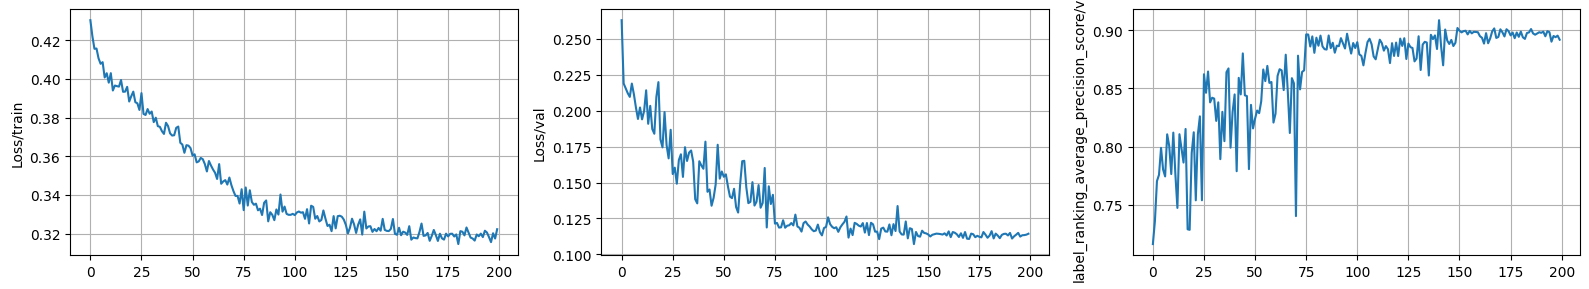

100%|██████████| 200/200 [1:13:11<00:00, 21.96s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

          alkane       0.92      0.83      0.87       806
          methyl       0.90      0.80      0.85       724
          alkene       0.98      0.26      0.41       180
          alkyne       0.00      0.00      0.00        27
        alcohols       0.91      0.57      0.70       282
          amines       0.87      0.30      0.44       151
        nitriles       0.00      0.00      0.00        43
       aromatics       0.94      0.90      0.92       705
   alkyl halides       0.80      0.39      0.52       300
          esters       0.97      0.45      0.62       142
         ketones       1.00      0.19      0.32       105
       aldehydes       0.00      0.00      0.00        27
carboxylic acids       0.87      0.25      0.39        79
           ether       0.91      0.55      0.69       302
    acyl halides       0.00      0.00      0.00        11
          amides       0.83      0.05      0.10        95
           ni

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [112]:
train_and_save_model(IrResnet7, '72', name = 'v0.7.2')

In [ ]:
# from torchsummary import summary
# summary(model.to(device), (3, 1800))

# Оценка качества модели

In [ ]:
#Очистка памяти GPU
import gc
torch.cuda.empty_cache()
gc.collect()

#Визуализация внимания

Только для версии v0.6.

In [ ]:
# model10.eval()
# data1 = []
# #Расчёт по тестовому даталоадеру предсказанных и реальных значений
# for data, label in dataloader_ir_val:
#     #print(data[0].unsqueeze(0).size())
#     data1 = data[3].unsqueeze(0)
#     out, a1, a2 = model10.to(device)(data1.to(device))
#     data1.to('cpu')
#     model10.to('cpu')
#     out.to('cpu')
#     a1.detach().to('cpu')
#     a2.detach().to('cpu')
#     break
# print(a1.size(), a2.size(), data1.size())

In [ ]:
# a11 = F.interpolate(a1.detach().to('cpu'), scale_factor=4)
# plt.plot(data1[0][0].detach().to('cpu'), a11[0][0])

In [ ]:
# a21 = F.interpolate(a2.detach().to('cpu'), scale_factor=8)
# plt.plot(data1[0][0].detach().to('cpu'), a11[0][0])

In [ ]:
# plt.plot(data1[0][0].detach().to('cpu'),data1[0][1].detach().to('cpu'))

In [ ]:
# def visualize_attention(I_train,a,up_factor,no_attention=False):
#     img = I_train.permute((1,2,0)).cpu().numpy()
#     # compute the heatmap
#     if up_factor > 1:
#         a = F.interpolate(a, scale_factor=up_factor, mode='bilinear', align_corners=False)
#     attn = utils.make_grid(a, nrow=8, normalize=True, scale_each=True)
#     attn = attn.permute((1,2,0)).mul(255).byte().cpu().numpy()
#     attn = cv2.applyColorMap(attn, cv2.COLORMAP_JET)
#     attn = cv2.cvtColor(attn, cv2.COLOR_BGR2RGB)
#     attn = np.float32(attn) / 255
#     # add the heatmap to the image
#     img=cv2.resize(img,(466,60))
#     if no_attention:
#         return torch.from_numpy(img)
#     else:
#         vis = 0.6 * img + 0.4 * attn
#         return torch.from_numpy(vis)

# Статистика

## 14.03.2023

Базовая модель - 0: 8 сверточных слоёв (3 макспула, после каждого удвоения признаков). hidden_size = 11. Точность 0.6 на 100 эпохах (переобучение). lr = 0.001
Количество параметров: порядка 18 млн

v0.1. 8 сверточных (3 макспула, удвоение 1 после второго). hidden_size = 11. Точность 0,45 на 40 эпохах, потом переобучение до 0,6. lr = 0.0005.
Количество параметров: 5,058,328

v0.2.0 вход+ 5 слоёв по 3 базовых блока по 2 сверки = 31 hidden_size = 11.сверточный слой. Hidden_size = 11. ;r = 0.0005. Точность 0.43 20 эпохах, потом переобучение. 
Количество параметров: 350,158

v0.2.0.1 вход+ 5 слоёв по 3 базовых блока по 2 сверки = 31 сверточный слой. Hidden_size = 20. lr = 0.0005. Точность 0.41 на 20 эпохах, потом переобучение. 
Количество параметров: 655,357

v0.2.1 вход+ 5 слоёв по 3 базовых блока по 2 сверки = 31 сверточный слой + 2 fc + 1 do (0.5). Hidden_size = 10. lr = 0.0005. label_ranking_average_precision_score **0,875** на 25 эпохах, потом переобучение. 
Количество параметров: 3,753,407

v0.2.2  вход+ 5 слоёв по 3 базовых блока по 2 сверки = 31 сверточный слой + 2 fc + 1 do (0.5) между первым и вторым fc. Hidden_size = 10. lr = 0.0005. label_ranking_average_precision_score **0,91** на 45 эпохах, потом переобучение. 
Количество параметров: 3,753,407

Подобрана функция для статистики. f1 score - дает среднее в 0,78.
Применил таки дропаут. 
v0.2.2  вход+ 5 слоёв по 3 базовых блока по 2 сверки = 31 сверточный слой + 2 fc + 1 do (0.5) между первым и вторым fc. Hidden_size = 10. lr = 0.0005. label_ranking_average_precision_score **0,80** на 66 эпохах, потом переобучение. Количество параметров: 3,753,407
На выходе полнота для низких классов вообще никакая. Хотя переобучение есть. Попробую снизить скорость и дропаут.

v0.2.3  вход+ 5 слоёв по 3 базовых блока по 2 сверки = 31 сверточный слой + 2 fc + 1 do (0.3) между первым и вторым fc. Hidden_size = 10. lr = 0.0003. label_ranking_average_precision_score **0,82** на 35 эпохах, потом переобучение. Количество параметров: 3,753,407
Полнота определения страдает для классов с низким содержанием.

v0.3.0 добавил  еще один дропаут и глубины.

вход+ 8 слоёв по 3 базовых блока по 2 сверки = 41 сверточный слой + 2 fc + 2 do (0.5 и 0,2) между первым и вторым fc. Hidden_size = 10. lr = 0.0003. label_ranking_average_precision_score **0.781 на 31 эпохе** , потом переобучение. Количество параметров: 3,907,127


##18.03.2023


18/03/2023
v0.3.1 убрал избыток сверток и добавил толщины.

вход+ 4 слоёв по 3 базовых блока по 2 сверки = 21 сверточный слой + 2 fc. 
Hidden_size = 20. 
lr = 0.0005. 

label_ranking_average_precision_score **0.871 на 8 эпохе** , потом переобучение. Количество параметров: 7,788,437.
Но в этом случае реколл для малых классов отличен от нуля. f1w - 0.76.
Добавим дропауты

v0.3.2 добавил дроп после flatten. Переобучение значительно снизилось. Не хватило 40 эпох. Высокий пресижон, но слабый рекол.Общий f1 0,5

вход+ 4 слоёв по 3 базовых блока по 2 сверки = 21 сверточный слой + 2 fc+1дроп. 
Hidden_size = 20. 
lr = 0.0005.  
label_ranking_average_precision_score ** 0.803 на 39 эпохе**

v0.3.3 увеличим толщину еще. вход+ 4 слоёв по 3 базовых блока по 2 сверки = 21 сверточный слой + 2 fc+1дроп. 
Hidden_size = 30. (Параметров 12,114,647) 
lr = 0.0005.  
label_ranking_average_precision_score **0.812 на 36 эпохе**


           precision    recall  f1-score   support
           alkane       0.97      0.51      0.67       812
           methyl       0.93      0.54      0.68       715
           alkene       1.00      0.10      0.19       165
           alkyne       1.00      0.16      0.27        19
         alcohols       0.94      0.18      0.31       271
           amines       1.00      0.07      0.13       159
         nitriles       1.00      0.02      0.04        46
        aromatics       0.98      0.75      0.85       681
    alkyl halides       0.92      0.14      0.24       317
           esters       0.97      0.43      0.60       129
          ketones       1.00      0.06      0.12       112
        aldehydes       1.00      0.39      0.56        23
    carboxylic acids    1.00      0.15      0.26        66
           ether        0.95      0.53      0.68       288
    acyl halides        0.50      0.07      0.12        14
          amides        0.60      0.03      0.06        96
           nitro        0.92      0.49      0.64        71

       micro avg        0.96      0.43      0.59      3984
       macro avg        0.92      0.27      0.38      3984
    weighted avg        0.95      0.43      0.55      3984
     samples avg        0.75      0.44      0.53      3984


v0.3.5 Повысим толщину еще. hidden_size = 50 (21,634,667 параметров). Модель не учится. А при расчёте статистики - еще и забивается память.

## 20.03.2023

20.03.2023
Добавлен взвешенный даталоадер на трейн. 

v0.3.6. 8 уровней по 3 базовых блока. Уже на 40 эпохах с lr = 0.001 выходит на плато. Потом уменьшение lr = 0.0005 и lr = 0.0001 приводит к улучшению результата максимум до label_ranking_average_precision_score 0.8 на 60 эпохе.
Но статистика говорит, что слабые классы всё равно не попадают под обучение.


                 precision    recall  f1-score   support

          alkane       0.94      0.64      0.76       818
          methyl       0.92      0.46      0.61       736
          alkene       0.90      0.17      0.29       159
          alkyne       0.00      0.00      0.00        21
        alcohols       0.89      0.14      0.25       270
          amines       0.83      0.16      0.26       153
        nitriles       0.00      0.00      0.00        34
       aromatics       0.99      0.82      0.90       712
    alkyl_halides      0.95      0.23      0.37       330
          esters       1.00      0.45      0.62       128
         ketones       0.91      0.18      0.31       109
       aldehydes       0.00      0.00      0.00        17
    carboxylic_acids   0.90      0.11      0.20        81
           ether       0.96      0.43      0.60       274
    acyl halides       1.00      0.17      0.29        12
          amides       1.00      0.08      0.15        74
           nitro       0.95      0.50      0.65        72

       micro avg       0.95      0.47      0.62      4000
       macro avg       0.77      0.27      0.37      4000
    weighted avg       0.92      0.47      0.59      4000
     samples avg       0.84      0.48      0.58      4000


v0.3.6.  4 уровней по 3 базовых блока.
label_ranking_average_precision_score  = 0.797 на 76 эпохе

                 precision    recall  f1-score   support

          alkane       0.99      0.48      0.64       818
          methyl       0.99      0.38      0.54       736
          alkene       0.00      0.00      0.00       159
          alkyne       1.00      0.24      0.38        21
        alcohols       1.00      0.12      0.22       270
          amines       0.00      0.00      0.00       153
        nitriles       0.00      0.00      0.00        34
       aromatics       0.99      0.44      0.61       712
    alkyl halides      1.00      0.00      0.01       330
          esters       0.00      0.00      0.00       128
         ketones       0.00      0.00      0.00       109
       aldehydes       0.50      0.06      0.11        17
    carboxylic acids   0.00      0.00      0.00        81
           ether       1.00      0.04      0.08       274
    acyl halides       0.00      0.00      0.00        12
          amides       1.00      0.01      0.03        74
           nitro       0.00      0.00      0.00        72

       micro avg       0.99      0.26      0.41      4000
       macro avg       0.50      0.10      0.15      4000
    weighted avg       0.81      0.26      0.36      4000
     samples avg       0.59      0.28      0.36      4000

Высокие точности для больших классов, никакие для слабых.

v0.3.7 Прикрутил AdaptiveMaxPool1d и планировщик (StepLR шаг 30 спектров, гамма = 0,2). label_ranking_average_precision_score = 0.83 на 73 эпохе
Статистика с толерантностью 0,9:

                  precision    recall  f1-score   support

          alkane       0.99      0.45      0.62       818
          methyl       0.96      0.26      0.41       736
          alkene       1.00      0.04      0.07       159
          alkyne       1.00      0.05      0.09        21
        alcohols       1.00      0.03      0.06       270
          amines       1.00      0.05      0.10       153
        nitriles       1.00      0.03      0.06        34
       aromatics       1.00      0.70      0.82       712
     alkyl halides     1.00      0.08      0.15       330
          esters       1.00      0.20      0.33       128
         ketones       1.00      0.04      0.07       109
       aldehydes       0.00      0.00      0.00        17
    carboxylic acids   1.00      0.05      0.09        81
           ether       1.00      0.26      0.41       274
    acyl halides       0.00      0.00      0.00        12
          amides       1.00      0.01      0.03        74
           nitro       1.00      0.32      0.48        72

       micro avg       0.99      0.31      0.47      4000
       macro avg       0.88      0.15      0.22      4000
    weighted avg       0.98      0.31      0.42      4000
     samples avg       0.71      0.32      0.42      4000

Статистика с толернатностью 0,7 - ф1 - 0,66

                  precision    recall  f1-score   support

          alkane       0.91      0.78      0.84       818
          methyl       0.89      0.69      0.78       736
          alkene       0.84      0.20      0.32       159
          alkyne       1.00      0.24      0.38        21
        alcohols       0.85      0.15      0.26       270
          amines       0.91      0.20      0.32       153
        nitriles       1.00      0.15      0.26        34
       aromatics       0.98      0.90      0.93       712
     alkyl halides     0.93      0.26      0.41       330
          esters       0.96      0.40      0.56       128
         ketones       0.92      0.21      0.34       109
       aldehydes       1.00      0.06      0.11        17
    carboxylic acids   0.94      0.19      0.31        81
           ether       0.95      0.50      0.65       274
    acyl halides       0.00      0.00      0.00        12
          amides       0.89      0.11      0.19        74
           nitro       0.97      0.51      0.67        72

       micro avg       0.93      0.56      0.70      4000
       macro avg       0.88      0.33      0.43      4000
    weighted avg       0.92      0.56      0.66      4000
     samples avg       0.88      0.58      0.67      4000


v0.3.8 hidden_size = 15 (5 млн параметров), 8 слоёв. два дропаута.
точность 0.825 на 170 эпохе.
Статистика на 0,7:

                precision    recall  f1-score   support

          alkane       0.94      0.79      0.86       818
          methyl       0.94      0.69      0.80       736
          alkene       1.00      0.08      0.14       159
          alkyne       0.00      0.00      0.00        21
        alcohols       0.94      0.35      0.51       270
          amines       0.97      0.20      0.34       153
        nitriles       0.00      0.00      0.00        34
       aromatics       0.96      0.89      0.92       712
     alkyl halides     0.97      0.09      0.17       330
          esters       0.94      0.12      0.22       128
         ketones       1.00      0.03      0.05       109
       aldehydes       0.00      0.00      0.00        17
    carboxylic acids   0.75      0.04      0.07        81
           ether       1.00      0.28      0.44       274
    acyl halides       0.00      0.00      0.00        12
          amides       0.50      0.01      0.03        74
           nitro       1.00      0.14      0.24        72

       micro avg       0.95      0.52      0.67      4000
       macro avg       0.70      0.22      0.28      4000
    weighted avg       0.92      0.52      0.60      4000
     samples avg       0.90      0.54      0.64      4000

Везде наблюдаются высокие precision и низкие recall, за исключением самых крупных классов. Самые редкие классы по нулям. 
Требуется научиться аугментации спектров, повысить количество малых классов, хотя бы раз в 10-100. 

Планы: 

*   Заняться аугментацией спектров
*   Самые редкие классы выделить и аугментировать многократно. 
*   Используя имеющуюся модель научиться определять полосы частых классов и аугментировать спектры, вырежая эти диапазоны.
*   Научиться работать со спектрами других размеров.






## 21.03.2023

v0.3.9 4 уровня скрытый уровень 10 Прикручена BCELosswithlogits убран слой с сигмоидом. Убран рандомный семплер. Веса в лосс обратные.

                  precision    recall  f1-score   support

          alkane       0.70      1.00      0.82       831
          methyl       0.63      1.00      0.77       750
          alkene       0.00      0.00      0.00       151
          alkyne       0.00      0.00      0.00        22
        alcohols       0.00      0.00      0.00       253
          amines       0.00      0.00      0.00       148
        nitriles       0.00      0.00      0.00        45
       aromatics       0.60      1.00      0.75       712
    alkyl halides      0.00      0.00      0.00       316
          esters       0.00      0.00      0.00       148
         ketones       0.00      0.00      0.00       105
       aldehydes       0.00      0.00      0.00        23
    carboxylic acids   0.00      0.00      0.00        84
           ether       0.00      0.00      0.00       311
    acyl halides       0.00      0.00      0.00        17
          amides       0.00      0.00      0.00        70
           nitro       0.00      0.00      0.00        63

       micro avg       0.64      0.57      0.60      4049
       macro avg       0.11      0.18      0.14      4049
    weighted avg       0.37      0.57      0.44      4049
     samples avg       0.64      0.60      0.60      4049


Обучение только на большие классы.

v0.3.10 BCELosswithlogits Веса в лосс прямые. 0.777 на 76 эпохе. Статистика на толерантности 0,8

                  precision    recall  f1-score   support

          alkane       0.94      0.76      0.84       831
          methyl       0.92      0.64      0.75       750
          alkene       0.94      0.11      0.19       151
          alkyne       0.00      0.00      0.00        22
        alcohols       0.98      0.17      0.30       253
          amines       1.00      0.01      0.03       148
        nitriles       0.00      0.00      0.00        45
       aromatics       0.97      0.90      0.93       712
    alkyl halides      1.00      0.15      0.26       316
          esters       0.97      0.38      0.54       148
         ketones       1.00      0.06      0.11       105
       aldehydes       0.00      0.00      0.00        23
    carboxylic acids   0.80      0.05      0.09        84
           ether       0.97      0.44      0.61       311
    acyl halides       0.00      0.00      0.00        17
          amides       0.00      0.00      0.00        70
           nitro       1.00      0.29      0.44        63

       micro avg       0.95      0.51      0.67      4049
       macro avg       0.68      0.23      0.30      4049
    weighted avg       0.91      0.51      0.60      4049
     samples avg       0.89      0.53      0.64      4049


Статистика с толерантностью 0,5

                 precision    recall  f1-score   support

          alkane       0.92      0.81      0.86       831
          methyl       0.89      0.72      0.79       750
          alkene       0.90      0.13      0.22       151
          alkyne       0.00      0.00      0.00        22
        alcohols       0.96      0.21      0.34       253
          amines       1.00      0.06      0.11       148
        nitriles       1.00      0.02      0.04        45
       aromatics       0.97      0.93      0.95       712
     alkyl halides     1.00      0.21      0.35       316
          esters       0.97      0.46      0.62       148
         ketones       1.00      0.10      0.19       105
       aldehydes       0.00      0.00      0.00        23
    carboxylic acids   0.80      0.05      0.09        84
           ether       0.96      0.53      0.68       311
    acyl halides       0.00      0.00      0.00        17
          amides       0.00      0.00      0.00        70
           nitro       1.00      0.37      0.53        63

       micro avg       0.94      0.57      0.71      4049
       macro avg       0.73      0.27      0.34      4049
    weighted avg       0.91      0.57      0.64      4049
     samples avg       0.89      0.58      0.68      4049

v0.3.11 Рандомный даталоадер вернут. **0.904** на 116 эпохе
Статистика на 0,5:

                  precision    recall  f1-score   support

          alkane       0.94      0.86      0.90       829
          methyl       0.92      0.81      0.86       767
          alkene       1.00      0.09      0.17       164
          alkyne       1.00      0.06      0.11        17
        alcohols       0.97      0.28      0.44       277
          amines       0.93      0.18      0.30       145
        nitriles       0.00      0.00      0.00        45
       aromatics       0.97      0.89      0.93       688
     alkyl halides     0.97      0.14      0.24       279
          esters       1.00      0.29      0.45       150
         ketones       0.00      0.00      0.00       107
       aldehydes       0.00      0.00      0.00        23
    carboxylic acids   0.91      0.13      0.23        75
           ether       0.99      0.41      0.58       312
    acyl halides       0.00      0.00      0.00        11
          amides       0.00      0.00      0.00        84
           nitro       0.93      0.21      0.34        62

       micro avg       0.95      0.57      0.71      4035
       macro avg       0.68      0.26      0.33      4035
    weighted avg       0.89      0.57      0.64      4035
     samples avg       0.91      0.59      0.69      4035


Начинает получаться с малыми классами. Появился реколл для классов 45-80 шт.
Надо увеличить еще веса для самых малых классов.

v0.3.12 Уменьшение весов малых классов еще сильнее. 

                  precision    recall  f1-score   support

          alkane       0.94      0.78      0.85       829
          methyl       0.95      0.71      0.81       767
          alkene       0.00      0.00      0.00       164
          alkyne       0.00      0.00      0.00        17
        alcohols       0.00      0.00      0.00       277
          amines       0.00      0.00      0.00       145
        nitriles       0.00      0.00      0.00        45
       aromatics       0.94      0.77      0.85       688
    alkyl halides      0.00      0.00      0.00       279
          esters       0.00      0.00      0.00       150
         ketones       0.00      0.00      0.00       107
       aldehydes       0.00      0.00      0.00        23
    carboxylic acids   0.00      0.00      0.00        75
           ether       1.00      0.06      0.12       312
    acyl halides       0.00      0.00      0.00        11
          amides       0.00      0.00      0.00        84
           nitro       0.00      0.00      0.00        62

       micro avg       0.94      0.43      0.59      4035
       macro avg       0.23      0.14      0.16      4035
    weighted avg       0.61      0.43      0.48      4035
     samples avg       0.87      0.47      0.58      4035

Не помогло. Увеличиваем веса. Но не сработало:

                  precision    recall  f1-score   support

          alkane       0.00      0.00      0.00       835
          methyl       0.00      0.00      0.00       742
          alkene       0.00      0.00      0.00       168
          alkyne       0.00      0.00      0.00        27
        alcohols       0.00      0.00      0.00       258
          amines       0.00      0.00      0.00       152
        nitriles       0.00      0.00      0.00        44
       aromatics       0.00      0.00      0.00       668
     alkyl halides     0.00      0.00      0.00       292
          esters       0.00      0.00      0.00       134
         ketones       0.00      0.00      0.00       120
       aldehydes       0.00      0.00      0.00        25
    carboxylic acids   0.00      0.00      0.00        63
           ether       0.00      0.00      0.00       283
    acyl halides       0.00      0.00      0.00        11
          amides       0.00      0.00      0.00        75
           nitro       0.00      0.00      0.00        52

       micro avg       0.00      0.00      0.00      3949
       macro avg       0.00      0.00      0.00      3949
    weighted avg       0.00      0.00      0.00      3949
     samples avg       0.00      0.00      0.00      3949

## 22.03.2023

Подкрутка весов немного помогла. Но мелкие классы всё еще плохо читаются: 

                precision    recall  f1-score   support

          alkane       0.90      0.84      0.87       835
          methyl       0.88      0.72      0.79       742
          alkene       0.96      0.14      0.24       168
          alkyne       0.00      0.00      0.00        27
        alcohols       0.85      0.18      0.30       258
          amines       0.92      0.07      0.13       152
        nitriles       0.00      0.00      0.00        44
       aromatics       0.96      0.90      0.93       668
     alkyl halides     0.91      0.28      0.43       292
          esters       0.94      0.46      0.61       134
         ketones       1.00      0.09      0.17       120
       aldehydes       0.00      0.00      0.00        25
    carboxylic acids   0.83      0.08      0.14        63
           ether       0.93      0.61      0.74       283
    acyl halides       0.00      0.00      0.00        11
          amides       0.83      0.07      0.12        75
           nitro       0.93      0.54      0.68        52

       micro avg       0.91      0.58      0.71      3949
       macro avg       0.70      0.29      0.36      3949
    weighted avg       0.89      0.58      0.65      3949
     samples avg       0.89      0.59      0.68      3949

Уменьшили веса для малых классов еще в 2 раза. Похоже не хватает времени доучить.

                  precision    recall  f1-score   support

          alkane       0.90      0.80      0.85       835
          methyl       0.90      0.65      0.76       742
          alkene       1.00      0.04      0.08       168
          alkyne       0.00      0.00      0.00        27
        alcohols       0.88      0.03      0.05       258
          amines       1.00      0.01      0.01       152
        nitriles       0.00      0.00      0.00        44
       aromatics       0.96      0.88      0.91       668
    alkyl halides      0.95      0.07      0.13       292
          esters       0.97      0.27      0.42       134
         ketones       1.00      0.03      0.05       120
       aldehydes       0.00      0.00      0.00        25
    carboxylic acids   0.00      0.00      0.00        63
           ether       0.99      0.37      0.54       283
    acyl halides       0.00      0.00      0.00        11
          amides       0.00      0.00      0.00        75
           nitro       1.00      0.12      0.21        52

       micro avg       0.92      0.49      0.64      3949
       macro avg       0.62      0.19      0.24      3949
    weighted avg       0.88      0.49      0.55      3949
     samples avg       0.88      0.51      0.62      3949

v0.4.0. добавлены макспулы между слоями и общее количество параметров снижено до 0,5 млн.

                 precision    recall  f1-score   support

          alkane       0.93      0.58      0.72       835
          methyl       0.88      0.44      0.59       742
          alkene       0.95      0.11      0.19       168
          alkyne       0.00      0.00      0.00        27
        alcohols       0.91      0.12      0.21       258
          amines       0.84      0.11      0.19       152
        nitriles       0.00      0.00      0.00        44
       aromatics       0.84      0.96      0.89       668
    alkyl halides      0.78      0.46      0.58       292
          esters       0.98      0.35      0.52       134
         ketones       0.92      0.09      0.17       120
       aldehydes       0.00      0.00      0.00        25
    carboxylic acids   0.00      0.00      0.00        63
           ether       0.96      0.45      0.61       283
    acyl halides       0.00      0.00      0.00        11
          amides       0.00      0.00      0.00        75
           nitro       0.94      0.33      0.49        52

       micro avg       0.88      0.47      0.61      3949
       macro avg       0.58      0.23      0.30      3949
    weighted avg       0.84      0.47      0.56      3949
     samples avg       0.79      0.48      0.57      3949

Обучается также, такая же скорость, но малые классы также не берет, даже при доучивании.

## 28.03.2023

v0.4.2.50-60. Убран адаптивный макс пул. Последние цифры hidden -size

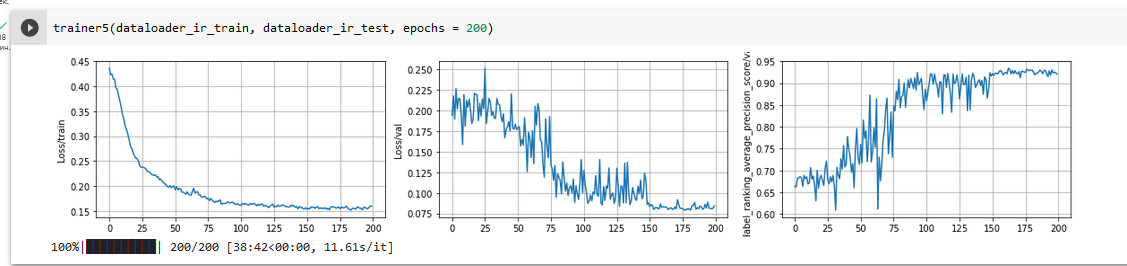

v0.4.2.20.raw - c адаптивным макс пулом обучена на неподготовленных данных.

v0.4.3.30 - обучение только на y

## 04.04.2023

v0.5.1.50 убрал два макс-пула. Количество параметров - 8 млн. 
По идее на начальных этапах двойное уменьшение размера ведёт к потери малых значений - что плохо для малых классов.

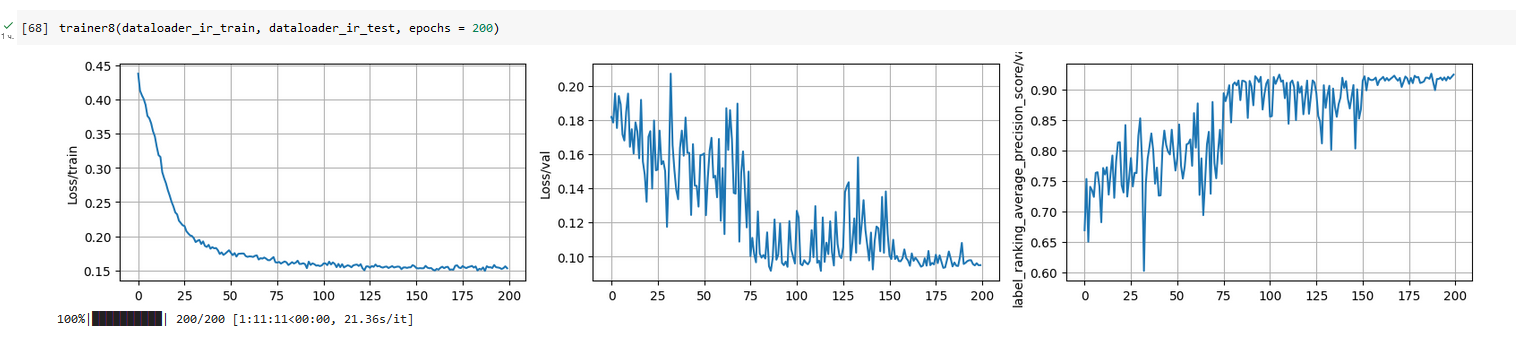

weighted f1 0.77

##02.06.2023
Добавлена версия v0.6.0. В версии убран один слой дропаутов. Добавлено два слоя внимания.
                  precision    recall  f1-score   support

          alkane       0.88      0.84      0.86       802
          methyl       0.84      0.77      0.80       725
          alkene       0.74      0.31      0.44       175
          alkyne       1.00      0.21      0.35        14
        alcohols       0.82      0.70      0.75       279
          amines       0.80      0.45      0.57       154
        nitriles       0.00      0.00      0.00        43
       aromatics       0.92      0.91      0.92       686
    alkyl halides      0.65      0.46      0.54       302
          esters       0.91      0.59      0.72       116
         ketones       0.83      0.26      0.39       112
       aldehydes       1.00      0.33      0.50        24
    carboxylic acids   0.88      0.26      0.40        82
           ether       0.85      0.49      0.62       280
    acyl halides       0.00      0.00      0.00         9
          amides       0.71      0.11      0.19        91
           nitro       0.88      0.31      0.46        70

       micro avg       0.85      0.66      0.74      3964
       macro avg       0.75      0.41      0.50      3964
    weighted avg       0.83      0.66      0.72      3964
     samples avg       0.85      0.67      0.72      3964

##03.06.2023

v0.6.0.10. Тестирование сети со скрытым слоем 10 и 20.

Обучение 10:

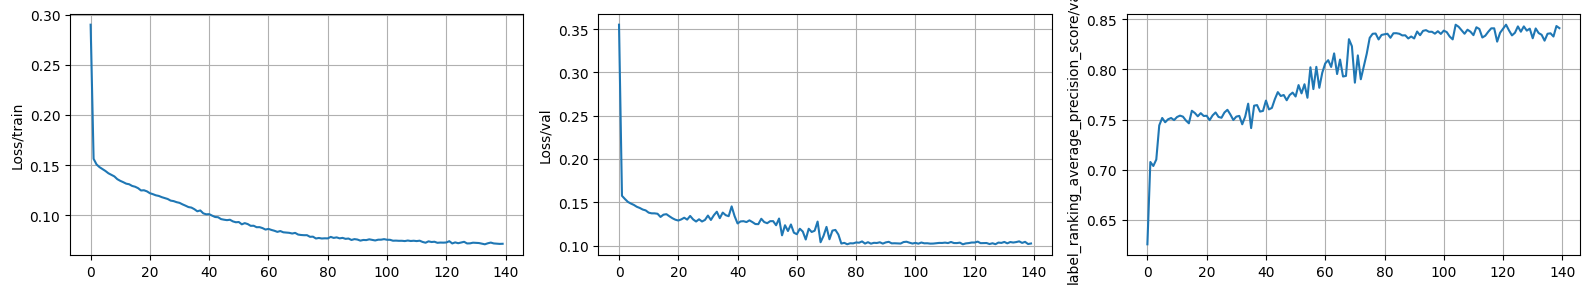

Обучение 20:

![изображение.png](
)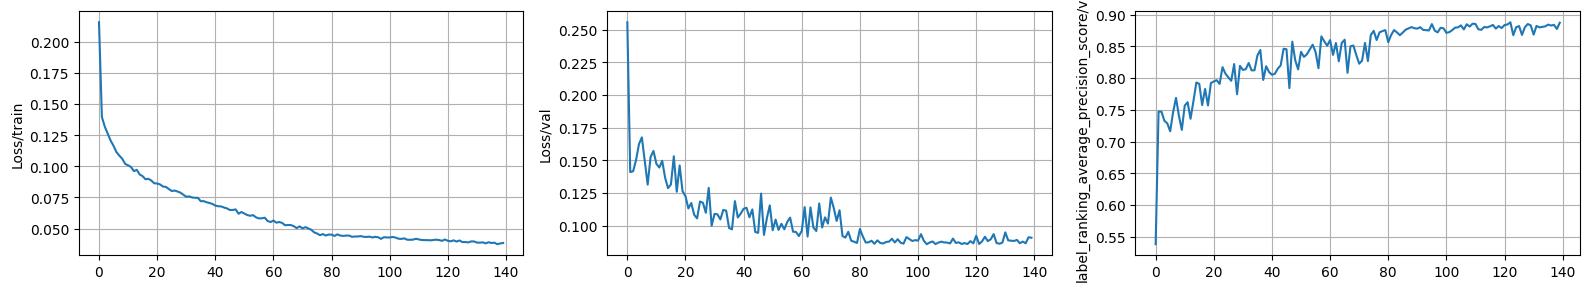

Сравнение статистик:

                  precision    recall  f1-score   support

          alkane       0.88      0.78      0.83       802
          methyl       0.89      0.69      0.78       725
          alkene       1.00      0.10      0.19       175
          alkyne       0.00      0.00      0.00        14
        alcohols       0.94      0.32      0.47       279
          amines       1.00      0.01      0.01       154
        nitriles       0.00      0.00      0.00        43
       aromatics       0.93      0.85      0.89       686
      alkyl halides    0.69      0.04      0.07       302
          esters       1.00      0.11      0.20       116
         ketones       0.00      0.00      0.00       112
       aldehydes       0.00      0.00      0.00        24
    carboxylic acids   0.00      0.00      0.00        82
           ether       0.94      0.21      0.34       280
    acyl halides       0.00      0.00      0.00         9
          amides       0.00      0.00      0.00        91
           nitro       0.00      0.00      0.00        70

       micro avg       0.90      0.48      0.63      3964
       macro avg       0.49      0.18      0.22      3964
    weighted avg       0.80      0.48      0.54      3964
     samples avg       0.86      0.50      0.61      3964

                  precision    recall  f1-score   support

          alkane       0.90      0.83      0.86       802
          methyl       0.87      0.79      0.83       725
          alkene       0.91      0.24      0.38       175
          alkyne       0.00      0.00      0.00        14
        alcohols       0.92      0.44      0.60       279
          amines       0.84      0.10      0.18       154
        nitriles       0.00      0.00      0.00        43
       aromatics       0.95      0.87      0.91       686
      alkyl halides    0.87      0.15      0.25       302
          esters       1.00      0.34      0.50       116
         ketones       0.80      0.04      0.07       112
       aldehydes       0.00      0.00      0.00        24
    carboxylic acids   0.67      0.02      0.05        82
           ether       0.94      0.35      0.51       280
    acyl halides       0.00      0.00      0.00         9
          amides       1.00      0.01      0.02        91
           nitro       0.00      0.00      0.00        70

       micro avg       0.91      0.55      0.69      3964
       macro avg       0.63      0.25      0.30      3964
    weighted avg       0.86      0.55      0.62      3964
     samples avg       0.87      0.57      0.66      3964

F1 повышается с 0.54 до 0.62

##v0.6.1 Добавлен второй дропаут.

##v0.7

v0.7.0 Добавлены 72 слоя мааксимумов для каждой полосы колебания
v0.7.1 72 слоя максимумов для каждой полосы колебания схлопнуты в один


# Конец